In [1]:
library(tidyverse)
library(here)
library(glue)
library(furrr)
library(cowplot)
library(lemon)
library(here)

devtools::load_all(".")

plan(multiprocess, workers = 30)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

here() starts at /mnt/expressions/mp/archaic-ychr


Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse


Loading required package: future


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************



Attaching package: ‘lemon’


The following object is masked from ‘package:purrr’:

    %||%


The following objects are masked from ‘package:ggplot

## Plot all trajectories across a grid

In [4]:
read_trajectories <- function(model, human_Ne, neand_Ne, admix_rates, reps) {
    future_map_dfr(reps, function(rep) {
    map_dfr(sprintf("%d", human_Ne), function(Ne1) {
    map_dfr(sprintf("%d", neand_Ne), function(Ne2) {
    map_dfr(sprintf("%0.2f", admix_rates), function(admix_rate) {

        f <- here(glue("data/sim/{model}/humanNe{Ne1}_neandNe{Ne2}_rate{admix_rate}_rep{rep}_traj.tsv"))

        read_tsv(f, col_types = "id") %>%
            mutate(human_Ne = as.integer(Ne1),
                   neand_Ne = as.integer(Ne2),
                   admix_rate = as.numeric(admix_rate),
                   rep = rep,
                   time = gen * 25)

    })
    })
    })
    })
}

In [5]:
traj <- read_trajectories(
    model = "tradeoff_Ne",
    human_Ne = 10000,
    neand_Ne = 1000,
    admix_rates = 0.05,
    reps = 1:10
)

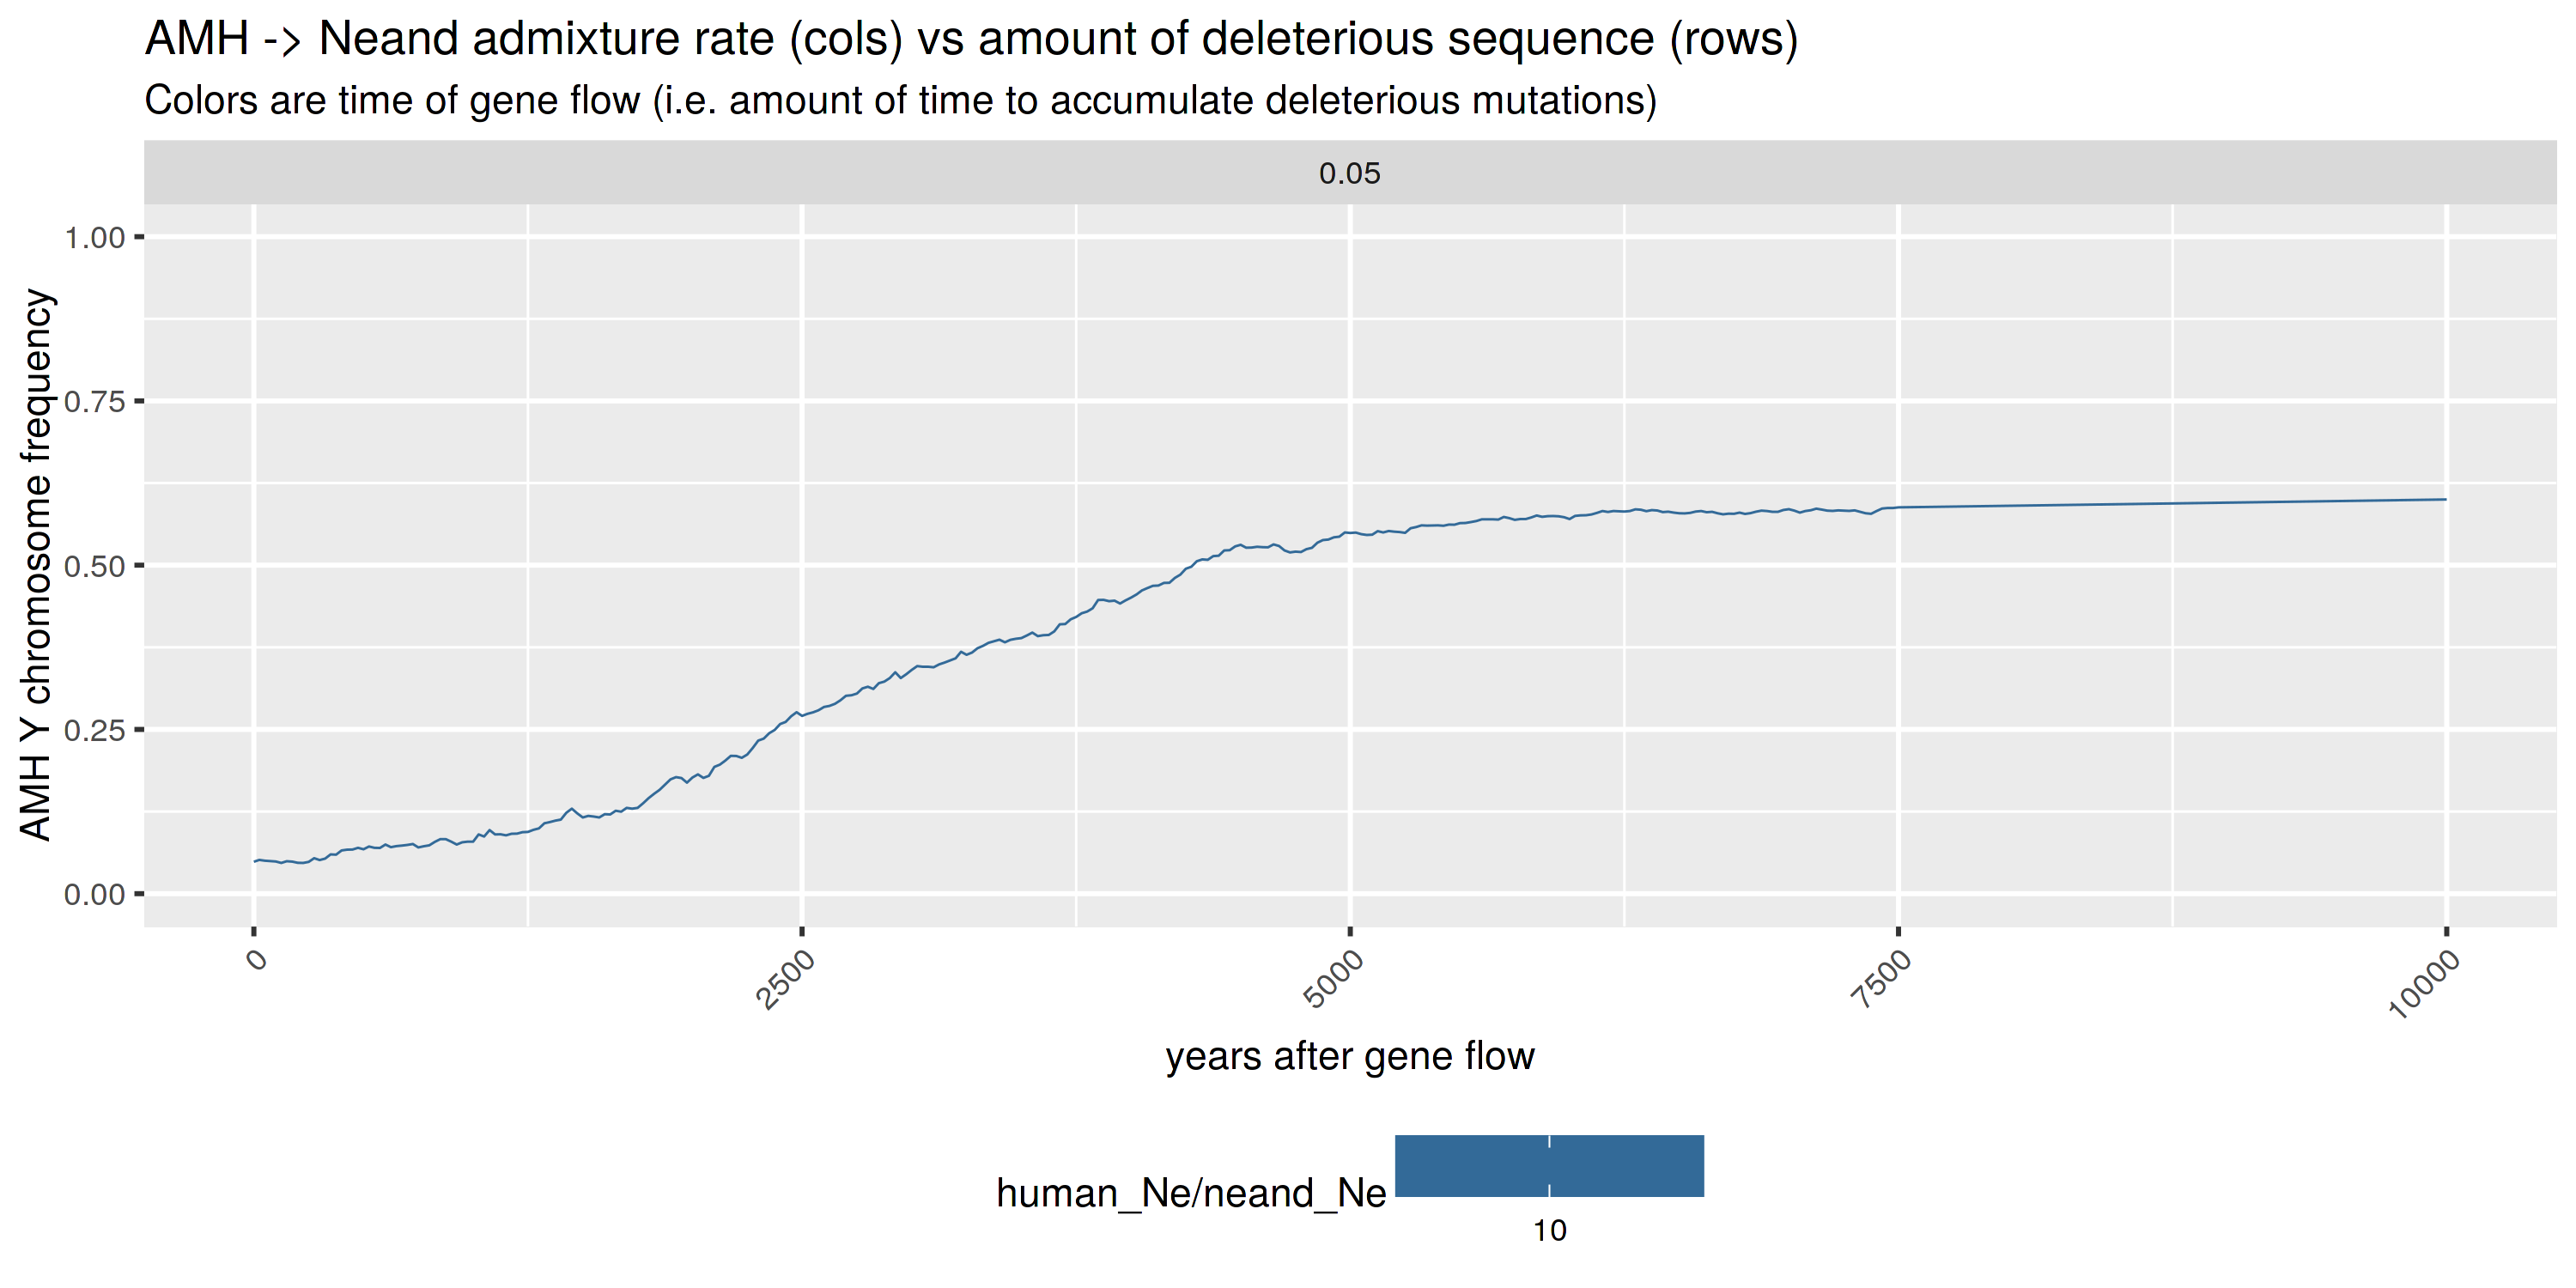

In [8]:
set_dim(10, 5)

traj %>%
filter(gen < 500) %>%
group_by(gen, time, human_Ne, neand_Ne, admix_rate) %>%
summarise(ancestry = mean(ancestry)) %>%
ggplot(aes(time, ancestry, color = human_Ne / neand_Ne)) +
    geom_line(size = 0.25) +
    ggtitle("AMH -> Neand admixture rate (cols) vs amount of deleterious sequence (rows)",
            "Colors are time of gene flow (i.e. amount of time to accumulate deleterious mutations)") +
    xlab("years after gene flow") + ylab("AMH Y chromosome frequency") +
    facet_grid(~ admix_rate) +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45)) +
    coord_cartesian(y = c(0, 1))

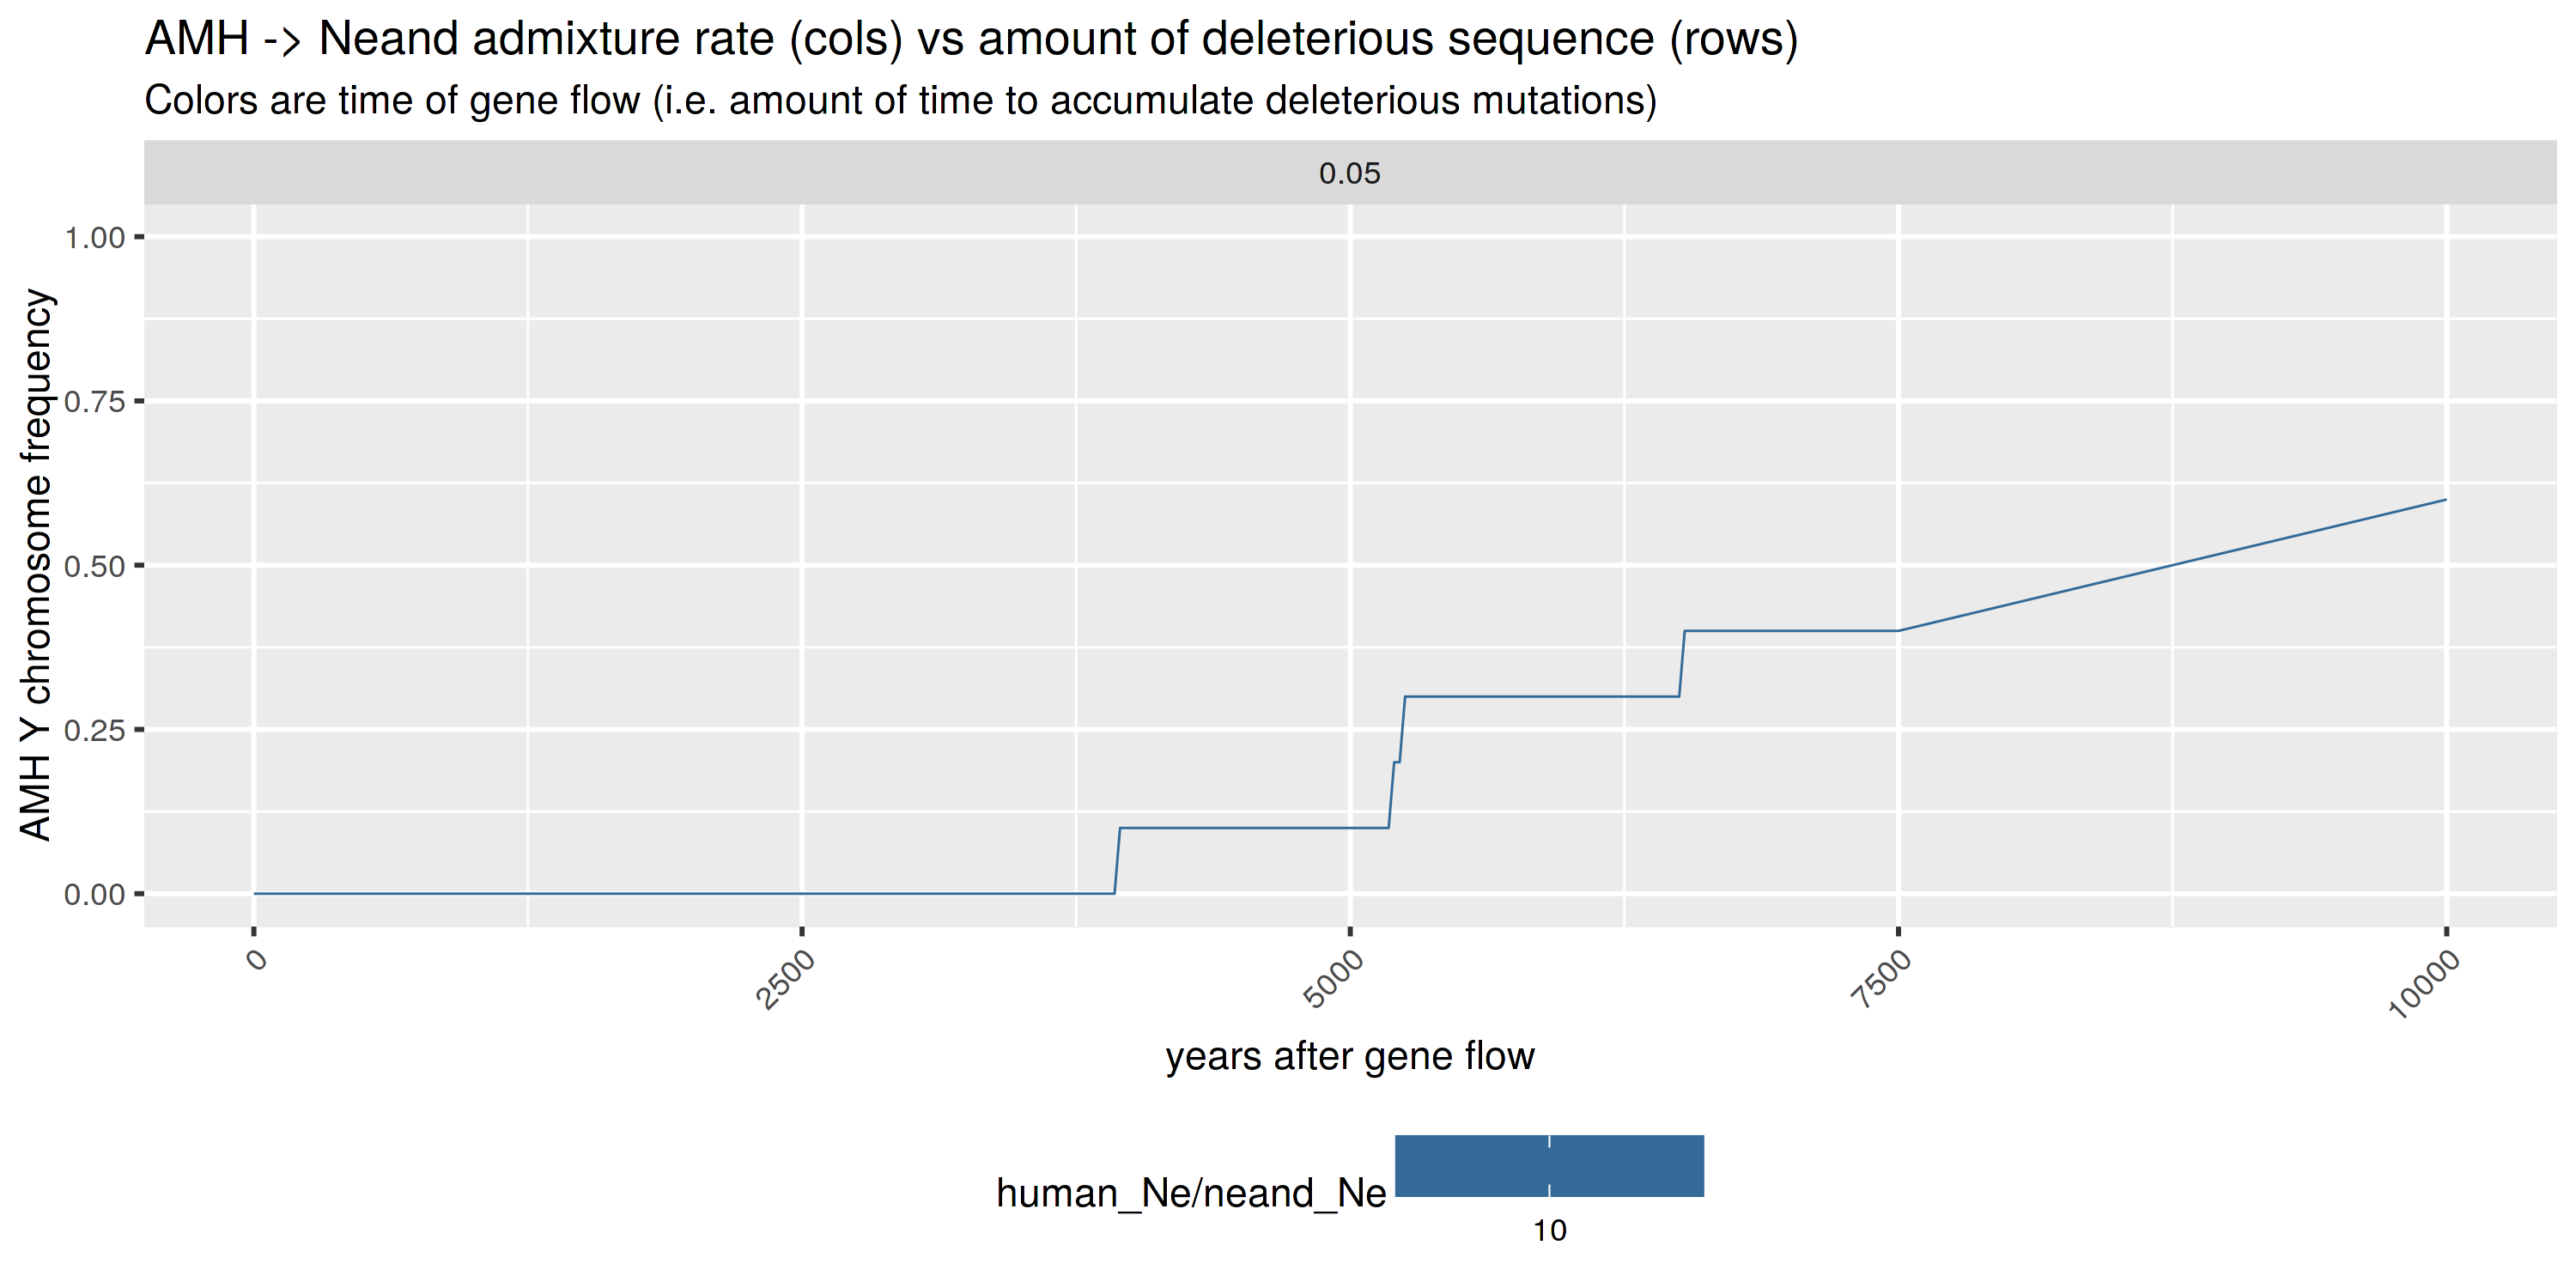

In [12]:
set_dim(10, 5)

traj %>%
filter(gen < 500) %>%
group_by(gen, time, human_Ne, neand_Ne, admix_rate) %>%
summarise(ancestry = mean(ancestry == 1)) %>%
ggplot(aes(time, ancestry, color = human_Ne / neand_Ne)) +
    geom_line(size = 0.25) +
    ggtitle("AMH -> Neand admixture rate (cols) vs amount of deleterious sequence (rows)",
            "Colors are time of gene flow (i.e. amount of time to accumulate deleterious mutations)") +
    xlab("years after gene flow") + ylab("AMH Y chromosome frequency") +
    facet_grid(~ admix_rate) +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45)) +
    coord_cartesian(y = c(0, 1))

## Assign fitness values to trajectories

In [20]:
read_fitness <- function(model, human_Ne, neand_Ne, admix_rates, reps) {
    future_map_dfr(reps, function(rep) {
    map_dfr(sprintf("%d", human_Ne), function(Ne1) {
    map_dfr(sprintf("%d", neand_Ne), function(Ne2) {
    map_dfr(sprintf("%0.2f", admix_rates), function(admix_rate) {

        f <- here(glue("data/sim/{model}/humanNe{Ne1}_neandNe{Ne2}_rate{admix_rate}_rep{rep}_pop.txt.gz"))

        read_slim(f) %>%
            calculate_fitness %>%
            mutate(human_Ne = as.integer(Ne1),
                   neand_Ne = as.integer(Ne2),
                   admix_rate = as.numeric(admix_rate),
                   rep = rep)

    })
    })
    })
    }) %>%
    mutate(pop = case_when(pop == "p1" ~ "AMH", pop == "p2" ~ "Neanderthals"))
}

In [26]:
suppressWarnings({ # this is just because of some recent dumb tidyverse cosmetic change in the tibble API
fitness <- read_fitness(
    model = "tradeoff_Ne",
    human_Ne = 10000,
    neand_Ne = 1000,
    admix_rates = 0.05,
    reps = 1:10
)
})

In [27]:
head(fitness)

genome_id,pop,S,fitness,human_Ne,neand_Ne,admix_rate,rep
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>
p1:10001,AMH,0.005840313,0.9941767,10000,1000,0.05,1
p1:10003,AMH,0.006766960,0.9932559,10000,1000,0.05,1
p1:10005,AMH,0.005848239,0.9941688,10000,1000,0.05,1
p1:10007,AMH,0.012212294,0.9878620,10000,1000,0.05,1
p1:10009,AMH,0.009279702,0.9907632,10000,1000,0.05,1
p1:10011,AMH,0.006477895,0.9935430,10000,1000,0.05,1


Calculate average fitness for each genome across all replicates:

In [28]:
mean_fitness <- fitness %>%
    group_by(genome_id, pop, human_Ne, neand_Ne, admix_rate) %>%
    summarise(fitness = mean(fitness))

In [29]:
head(mean_fitness)

genome_id,pop,human_Ne,neand_Ne,admix_rate,fitness
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>
p1:10001,AMH,10000,1000,0.05,0.9897665
p1:10003,AMH,10000,1000,0.05,0.9901163
p1:10005,AMH,10000,1000,0.05,0.9893961
p1:10007,AMH,10000,1000,0.05,0.9915051
p1:10009,AMH,10000,1000,0.05,0.9908232
p1:10011,AMH,10000,1000,0.05,0.9887280


geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



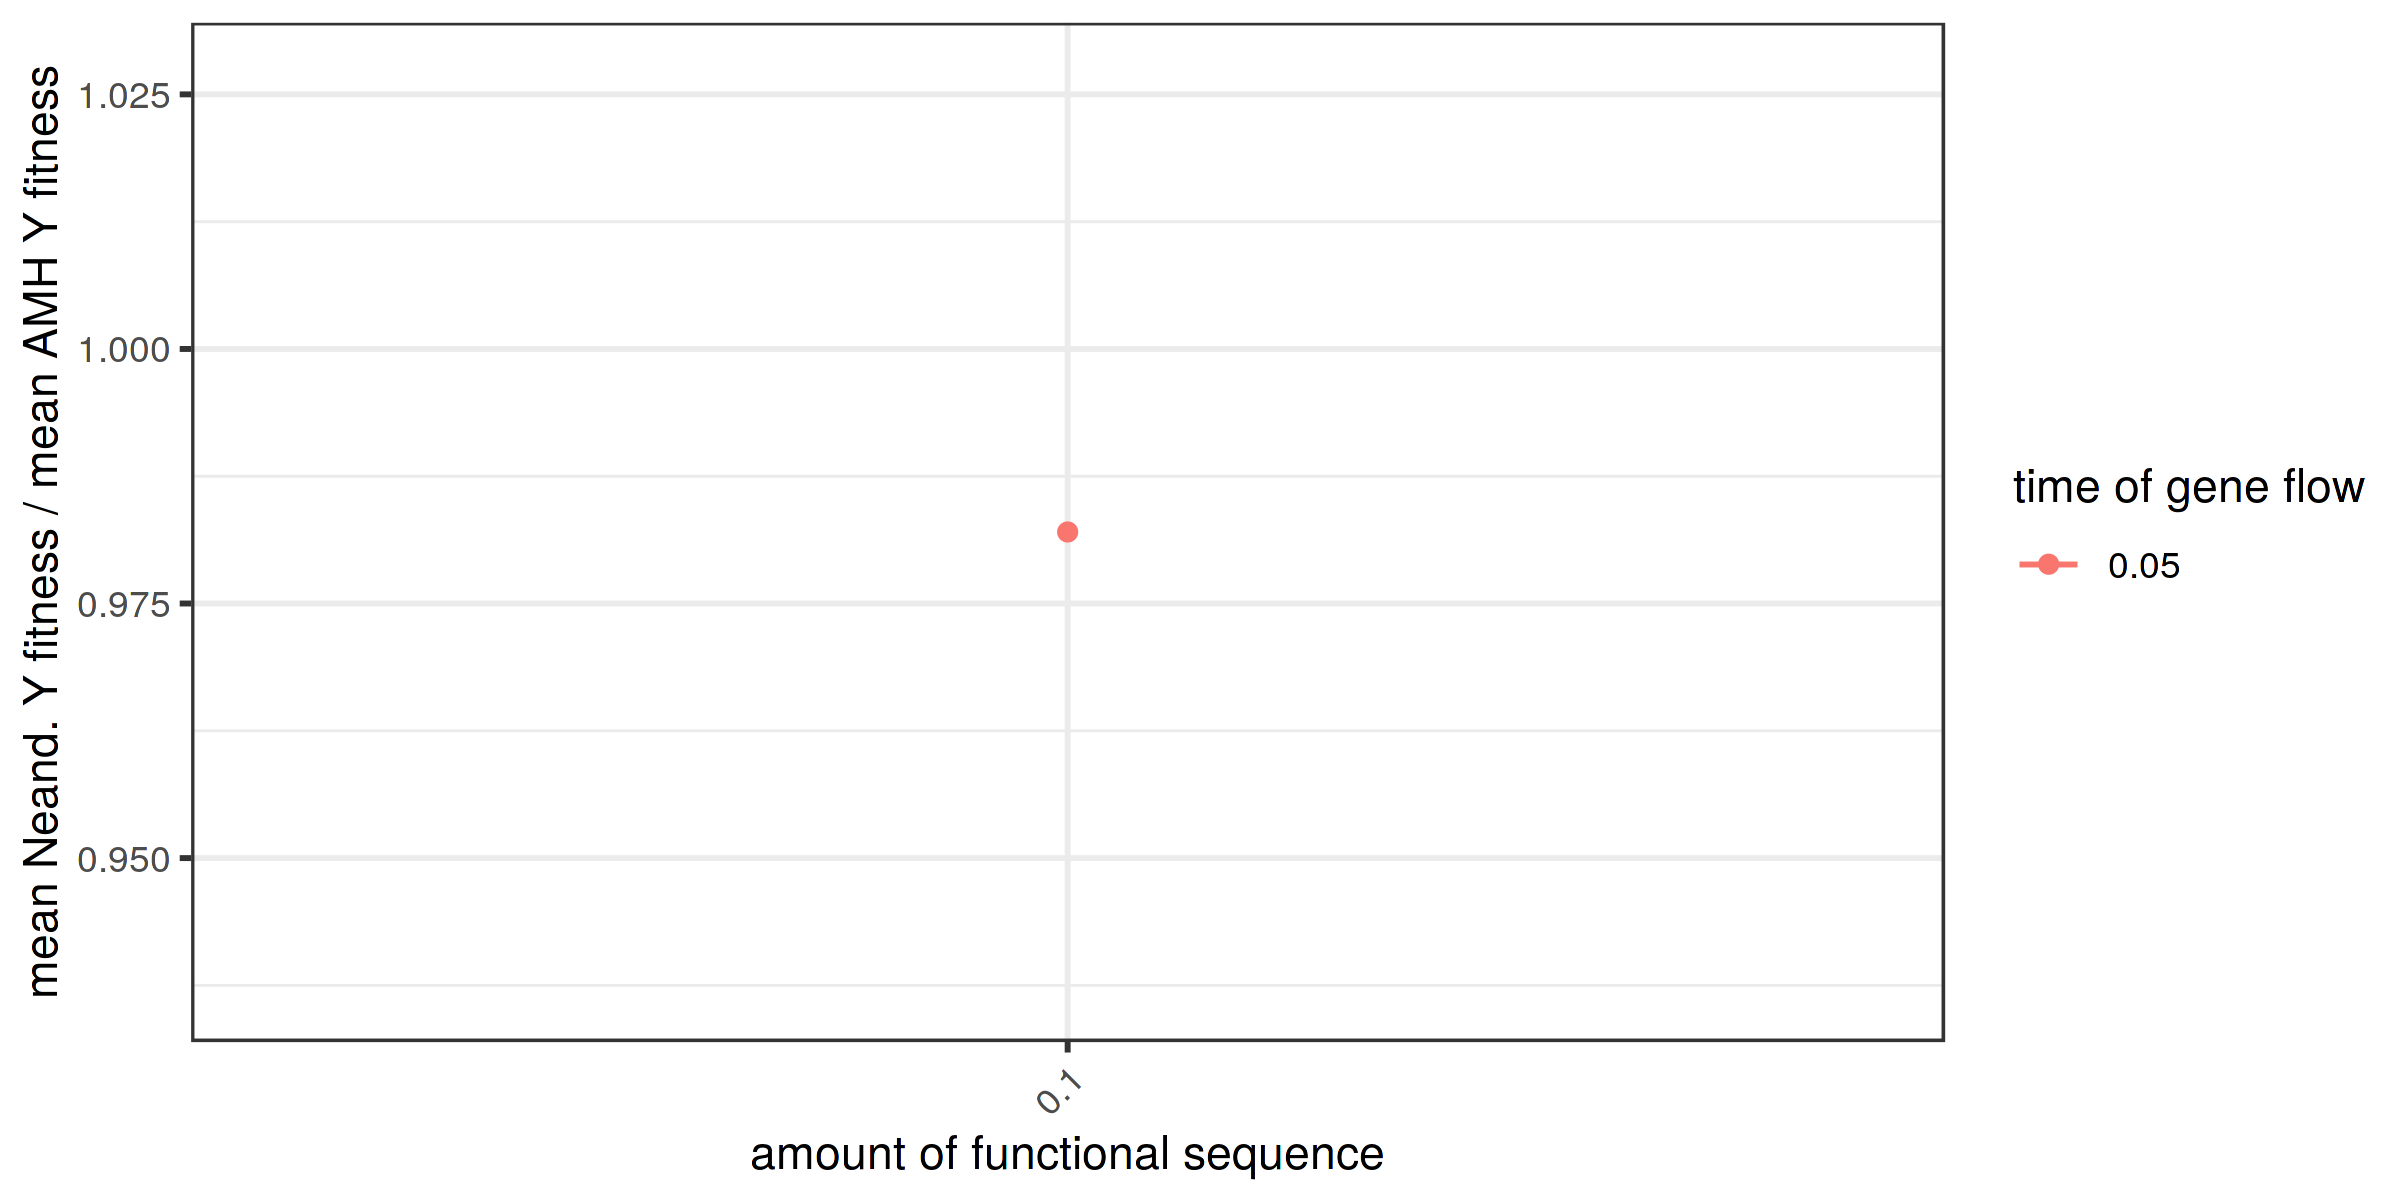

In [31]:
set_dim(8, 4)

mean_fitness %>%
ungroup %>%
group_by(pop, human_Ne, neand_Ne, admix_rate) %>%
summarise(fitness = mean(fitness)) %>%
spread(pop, fitness) %>%
mutate(ratio = Neanderthals / AMH) %>%
ggplot(aes(factor(neand_Ne / human_Ne), ratio, color = factor(admix_rate), group = factor(admix_rate))) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    labs(color = "time of gene flow",
         y = "mean Neand. Y fitness / mean AMH Y fitness",
         x = "amount of functional sequence")

Annotate each replicate trajectory with the value of Neanderthal and AMH loads prior to the gene flow event:

In [32]:
traj_fitness <- fitness %>%
    group_by(pop, rep, human_Ne, neand_Ne, admix_rate) %>%
    summarise_if(is.numeric, mean) %>%
    select(-S) %>%
    spread(pop, fitness) %>%
    mutate(ratio = 1 - Neanderthals / AMH) %>%
    inner_join(traj) %>% mutate(time = gen * 25)

Joining, by = c("rep", "human_Ne", "neand_Ne", "admix_rate")



In [33]:
head(traj_fitness)

rep,human_Ne,neand_Ne,admix_rate,AMH,Neanderthals,ratio,gen,ancestry,time
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,10000,1000,0.05,0.987668,0.9809836,0.006767865,0,0.044,0
1,10000,1000,0.05,0.987668,0.9809836,0.006767865,1,0.044,25
1,10000,1000,0.05,0.987668,0.9809836,0.006767865,2,0.042,50
1,10000,1000,0.05,0.987668,0.9809836,0.006767865,3,0.036,75
1,10000,1000,0.05,0.987668,0.9809836,0.006767865,4,0.050,100
1,10000,1000,0.05,0.987668,0.9809836,0.006767865,5,0.040,125


Assign trajectories to bins based on the relative Neand/AMH fitness:

In [34]:
mean_traj_fitness <- traj_fitness %>%
    group_by(gen, time, human_Ne, neand_Ne, admix_rate) %>%
    summarise(ancestry = mean(ancestry),
              ratio = mean(ratio))

In [35]:
min(mean_traj_fitness$ratio)

[1] 0.01796927

In [36]:
max(mean_traj_fitness$ratio)

[1] 0.01796927

In [37]:
(boundaries <- c(0.0, seq(0.005, 0.16, 0.01)))

[1] 0.000 0.005 0.015 0.025 0.035 0.045 0.055 0.065 0.075 0.085 0.095 0.105
[13] 0.115 0.125 0.135 0.145 0.155

In [38]:
mean_traj_fitness <- mean_traj_fitness %>% mutate(fitness_bin = cut(ratio, boundaries))

In [39]:
mean_traj_fitness$fitness_bin %>% table

.
    (0,0.005] (0.005,0.015] (0.015,0.025] (0.025,0.035] (0.035,0.045] 
            0             0           338             0             0 
(0.045,0.055] (0.055,0.065] (0.065,0.075] (0.075,0.085] (0.085,0.095] 
            0             0             0             0             0 
(0.095,0.105] (0.105,0.115] (0.115,0.125] (0.125,0.135] (0.135,0.145] 
            0             0             0             0             0 
(0.145,0.155] 
            0 

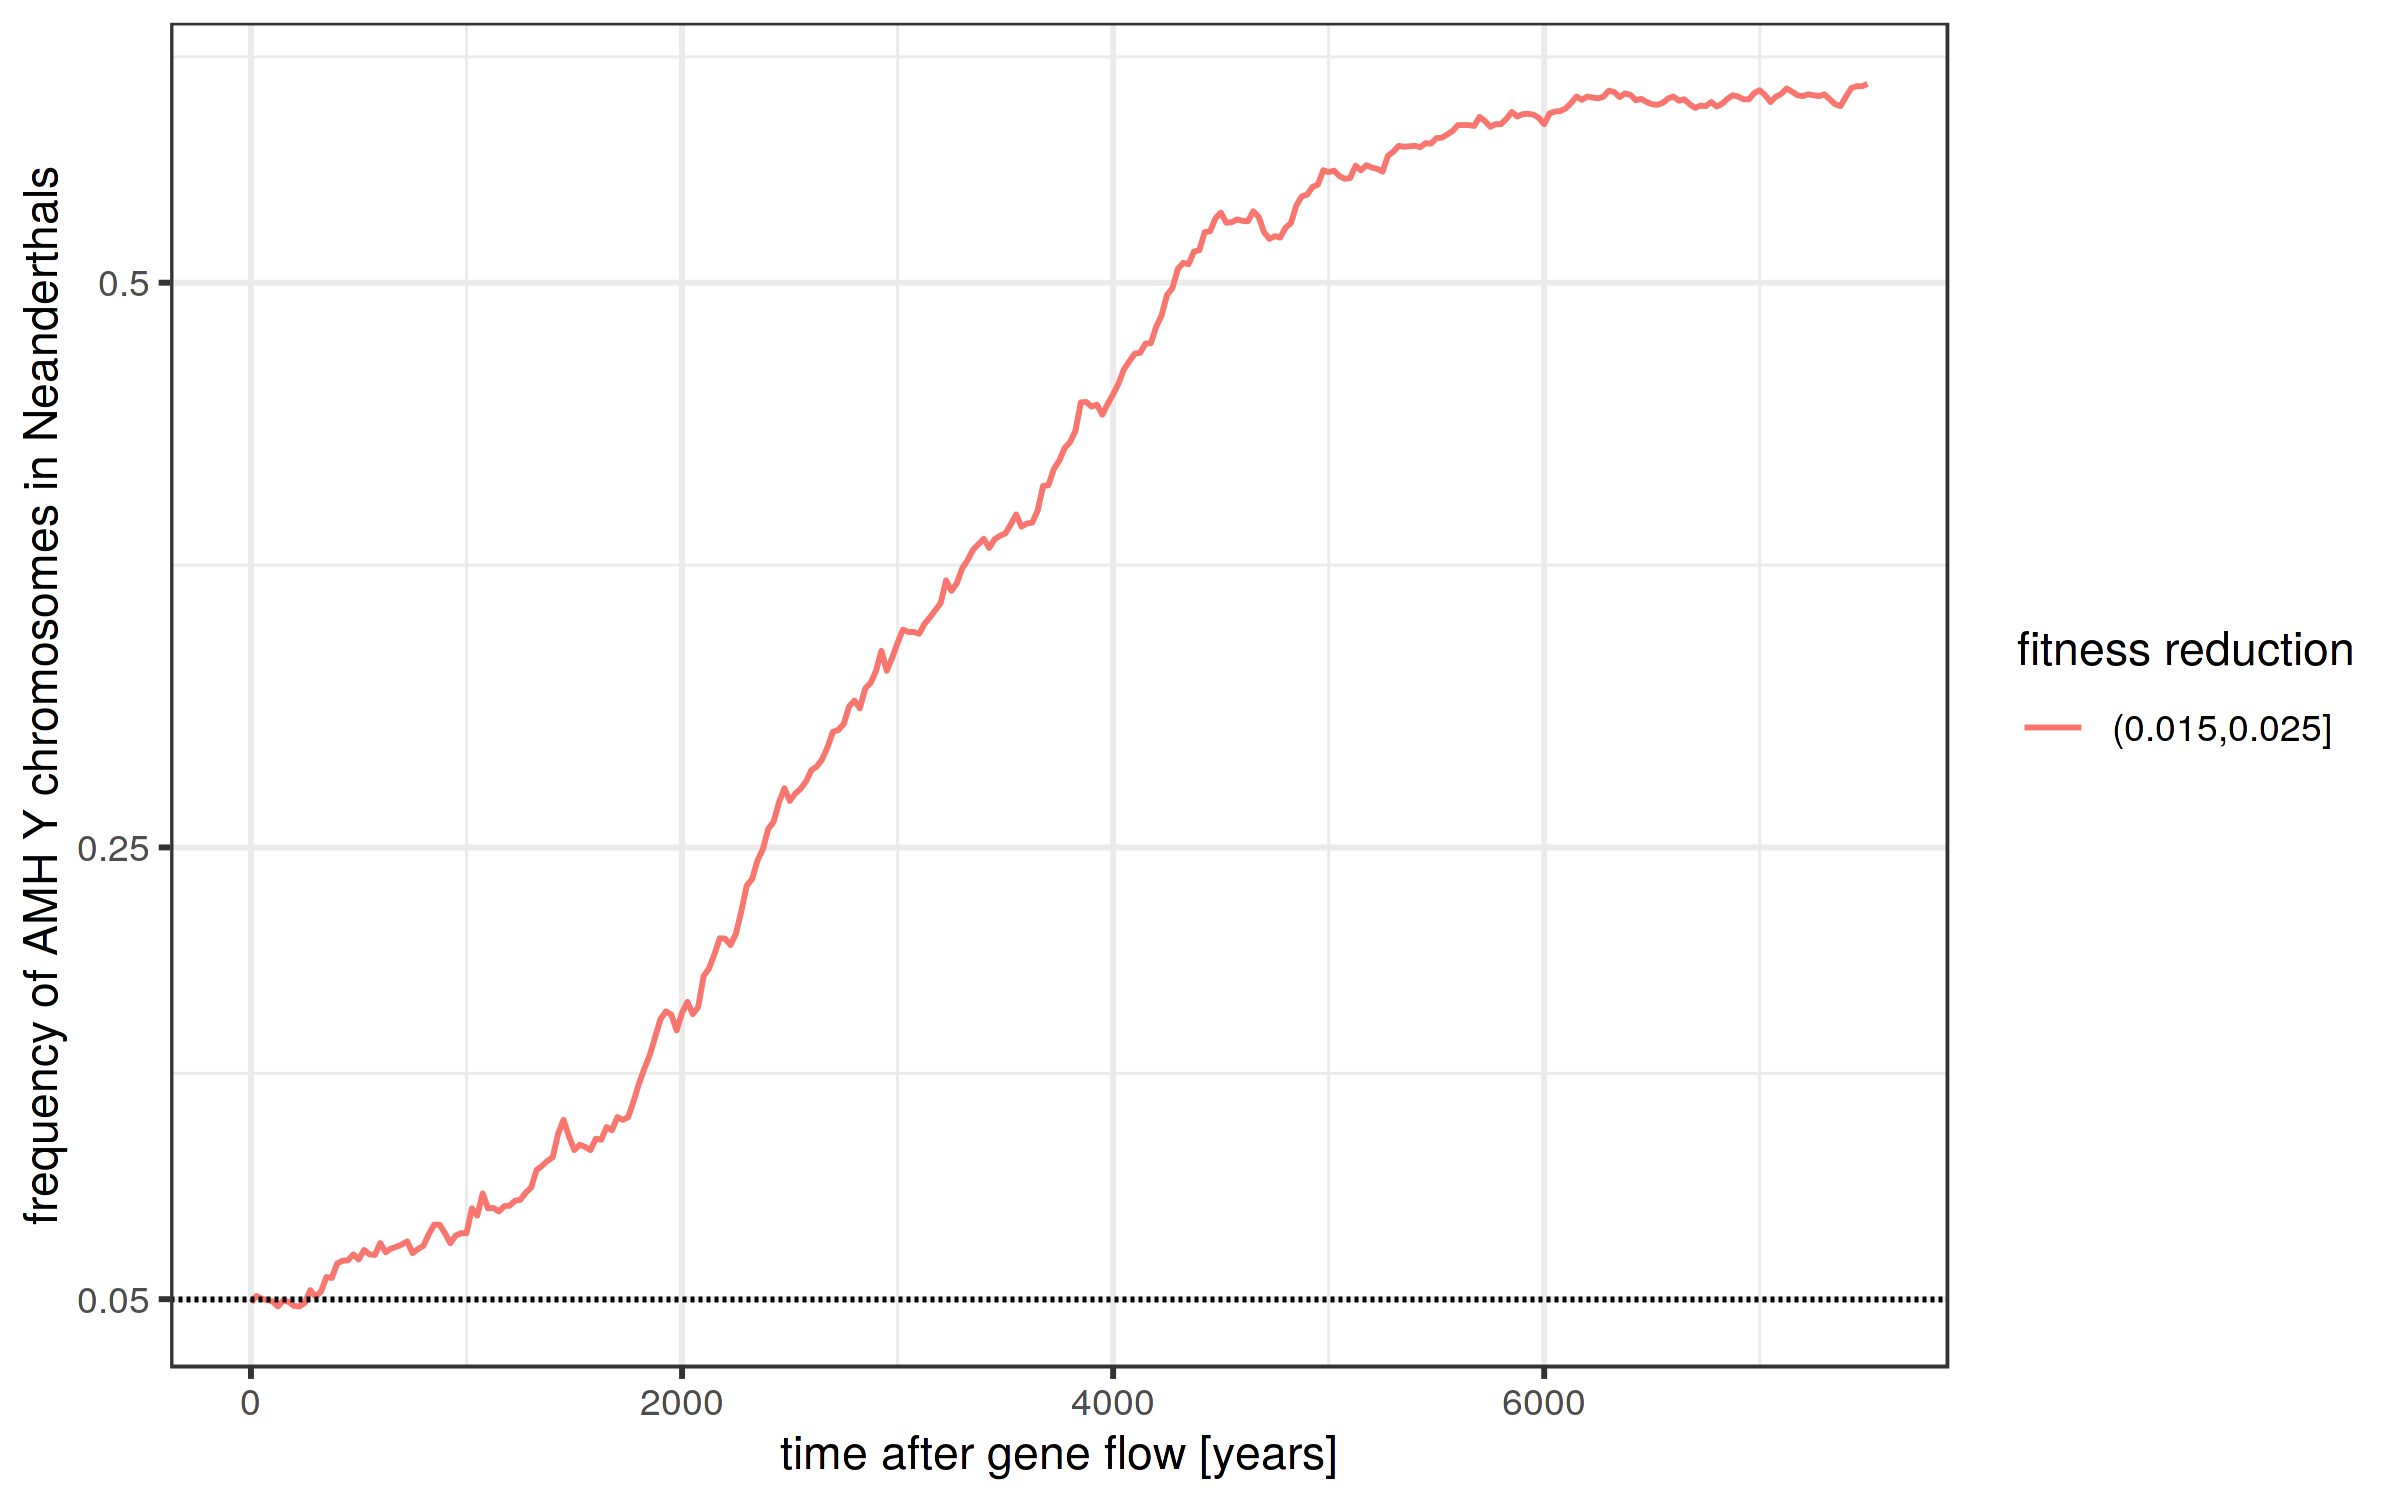

In [41]:
set_dim(8, 5)

mean_traj_fitness %>%
filter(gen < 400) %>%
ggplot(aes(time, ancestry, color = fitness_bin)) +
    geom_line(aes(group = interaction(neand_Ne / human_Ne, admix_rate))) +
    geom_hline(yintercept = 0.05, linetype = 2) +
    theme_bw() +
    labs(color = "fitness reduction",
         y = "frequency of AMH Y chromosomes in Neanderthals",
         x = "time after gene flow [years]") +
    scale_y_continuous(breaks = c(0, 0.05, 0.25, 0.5, 0.75, 1), labels= c(0, 0.05, 0.25, 0.5, 0.75, 1))

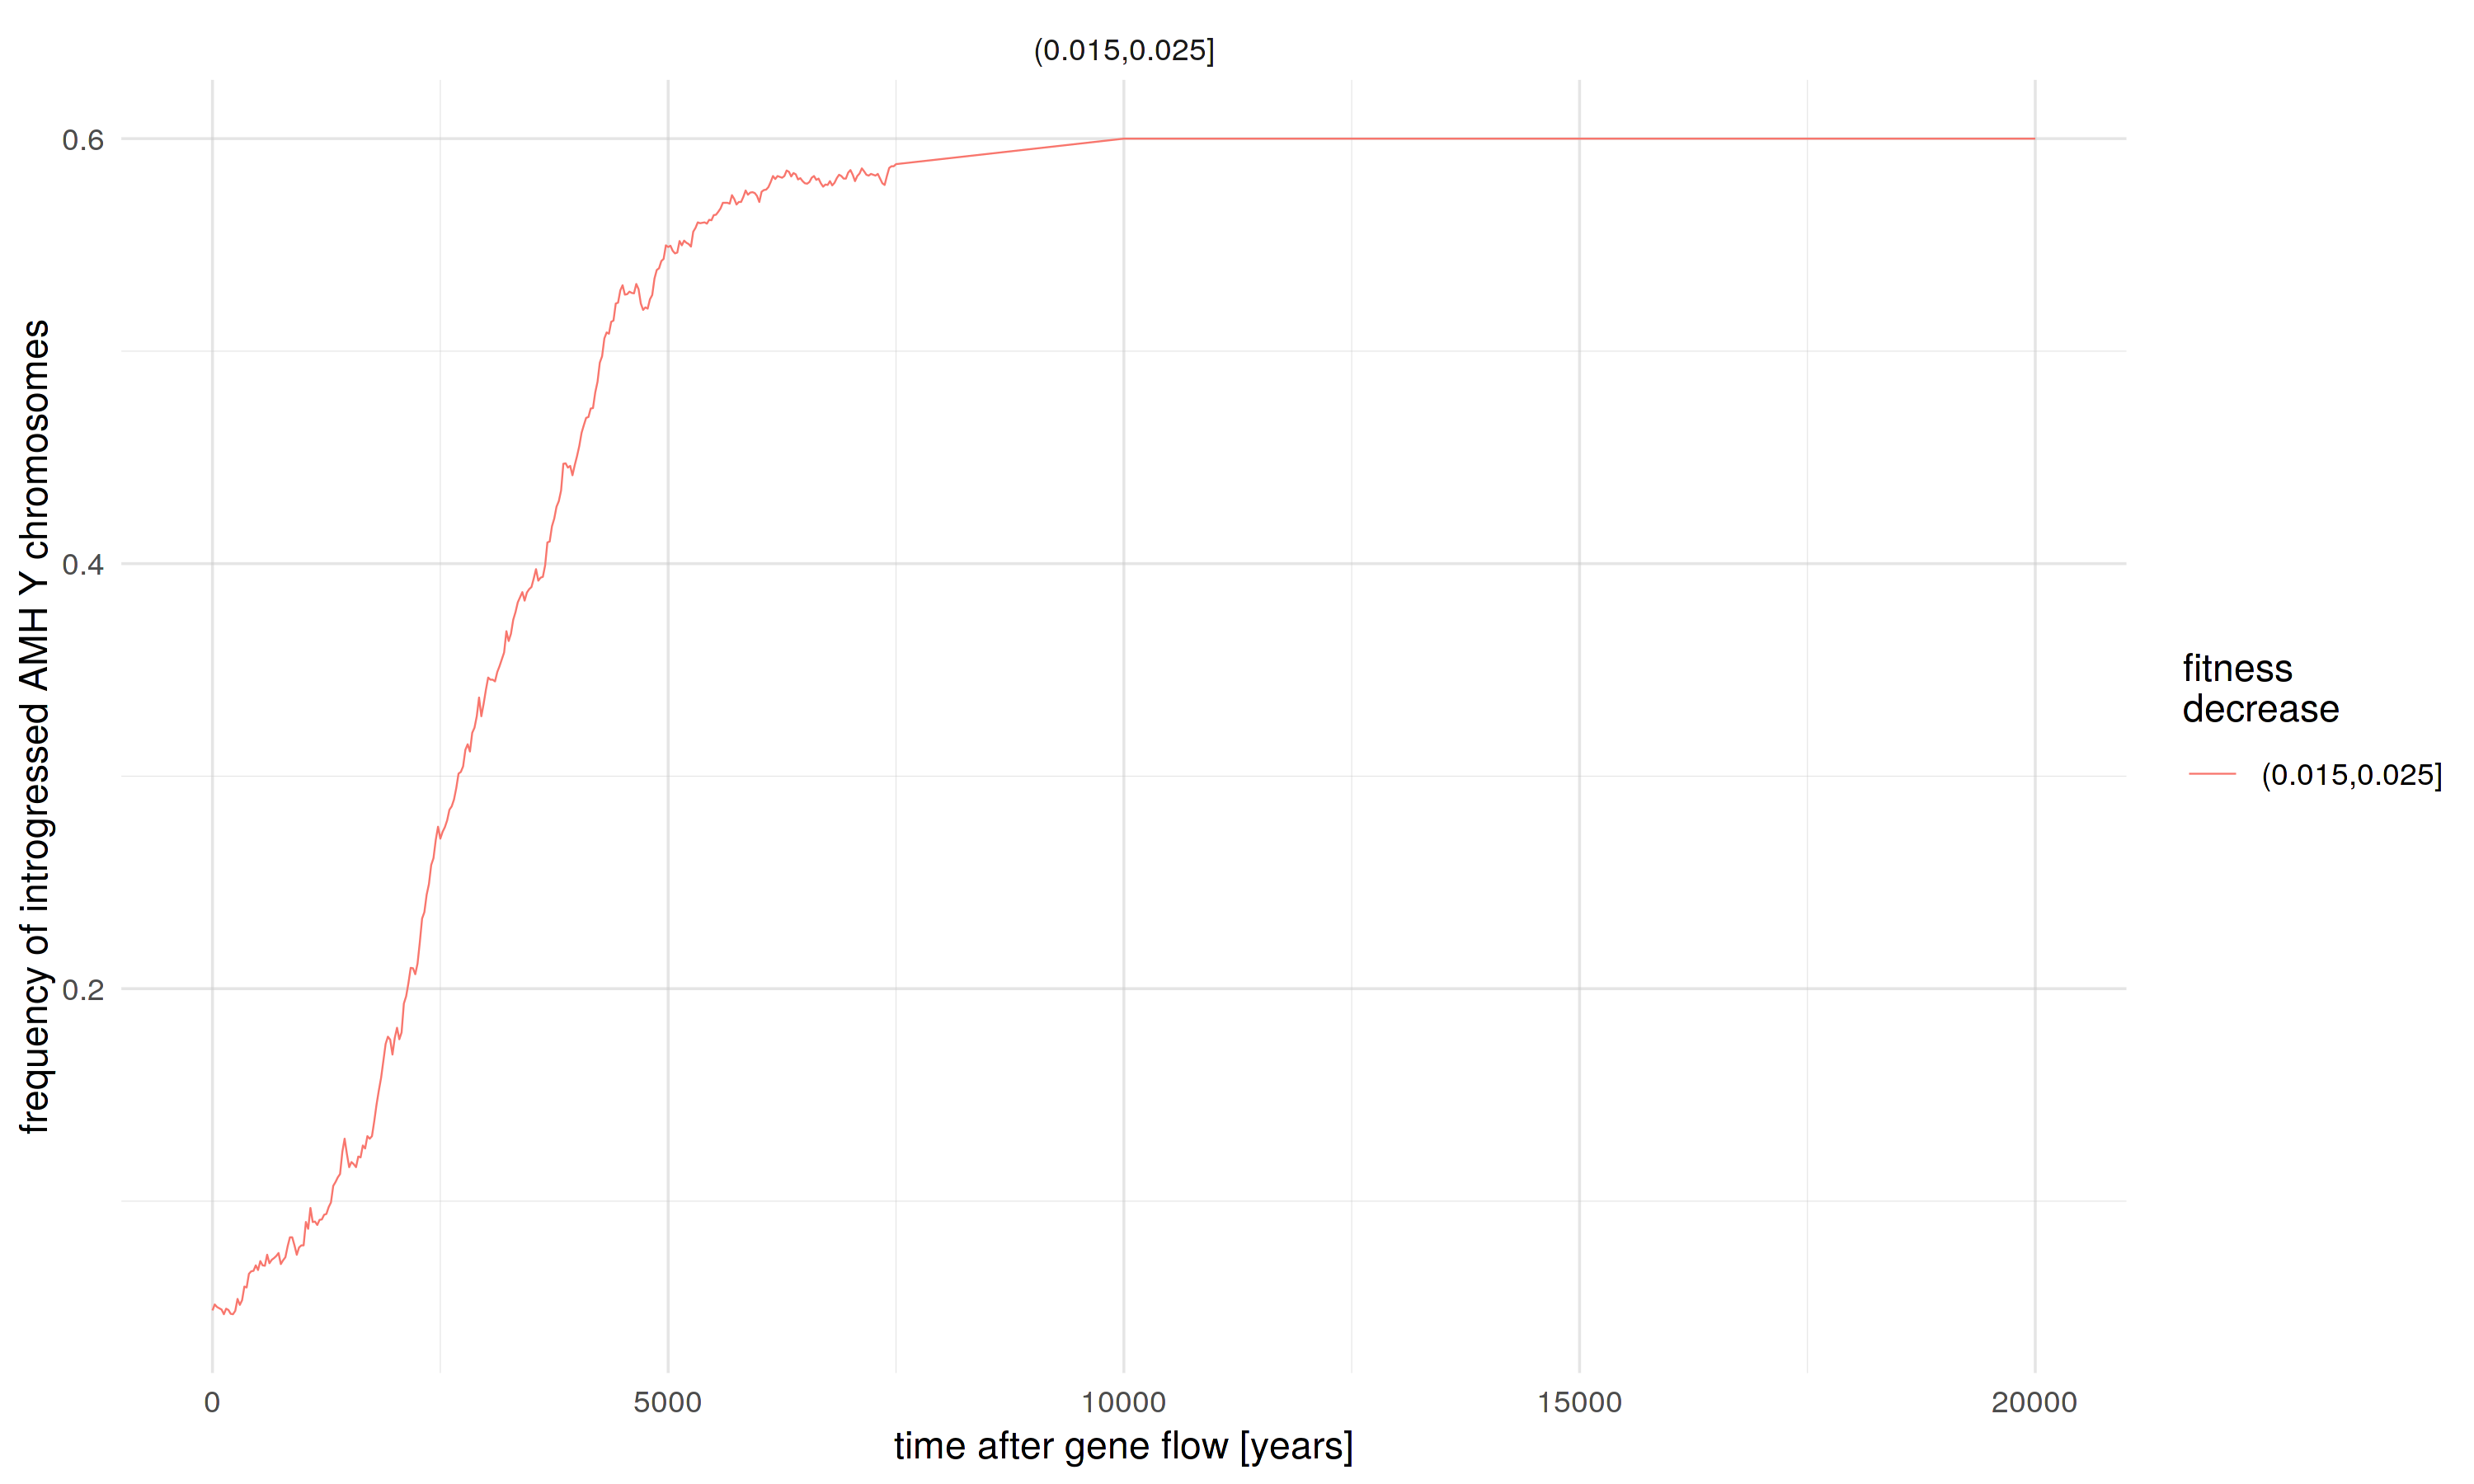

In [42]:
set_dim(10, 6)

mean_traj_fitness %>%
filter(time <= 20000) %>%
ggplot(aes(time, ancestry, color = fitness_bin)) +
    geom_line(aes(group = interaction(neand_Ne / human_Ne, admix_rate)), size = 1/5) +
    facet_wrap(~ fitness_bin) +
    theme_minimal() +
    background_grid(
        major = "xy", minor = "xy", size.major = 0.3, size.minor = 0.1,
        color.major = rgb(0.8, 0.8, 0.8, alpha = 0.5),
        color.minor = rgb(0.8, 0.8, 0.8, alpha = 0.5)
    ) +
    labs(color = "fitness\ndecrease",
         y = "frequency of introgressed AMH Y chromosomes",
         x = "time after gene flow [years]")

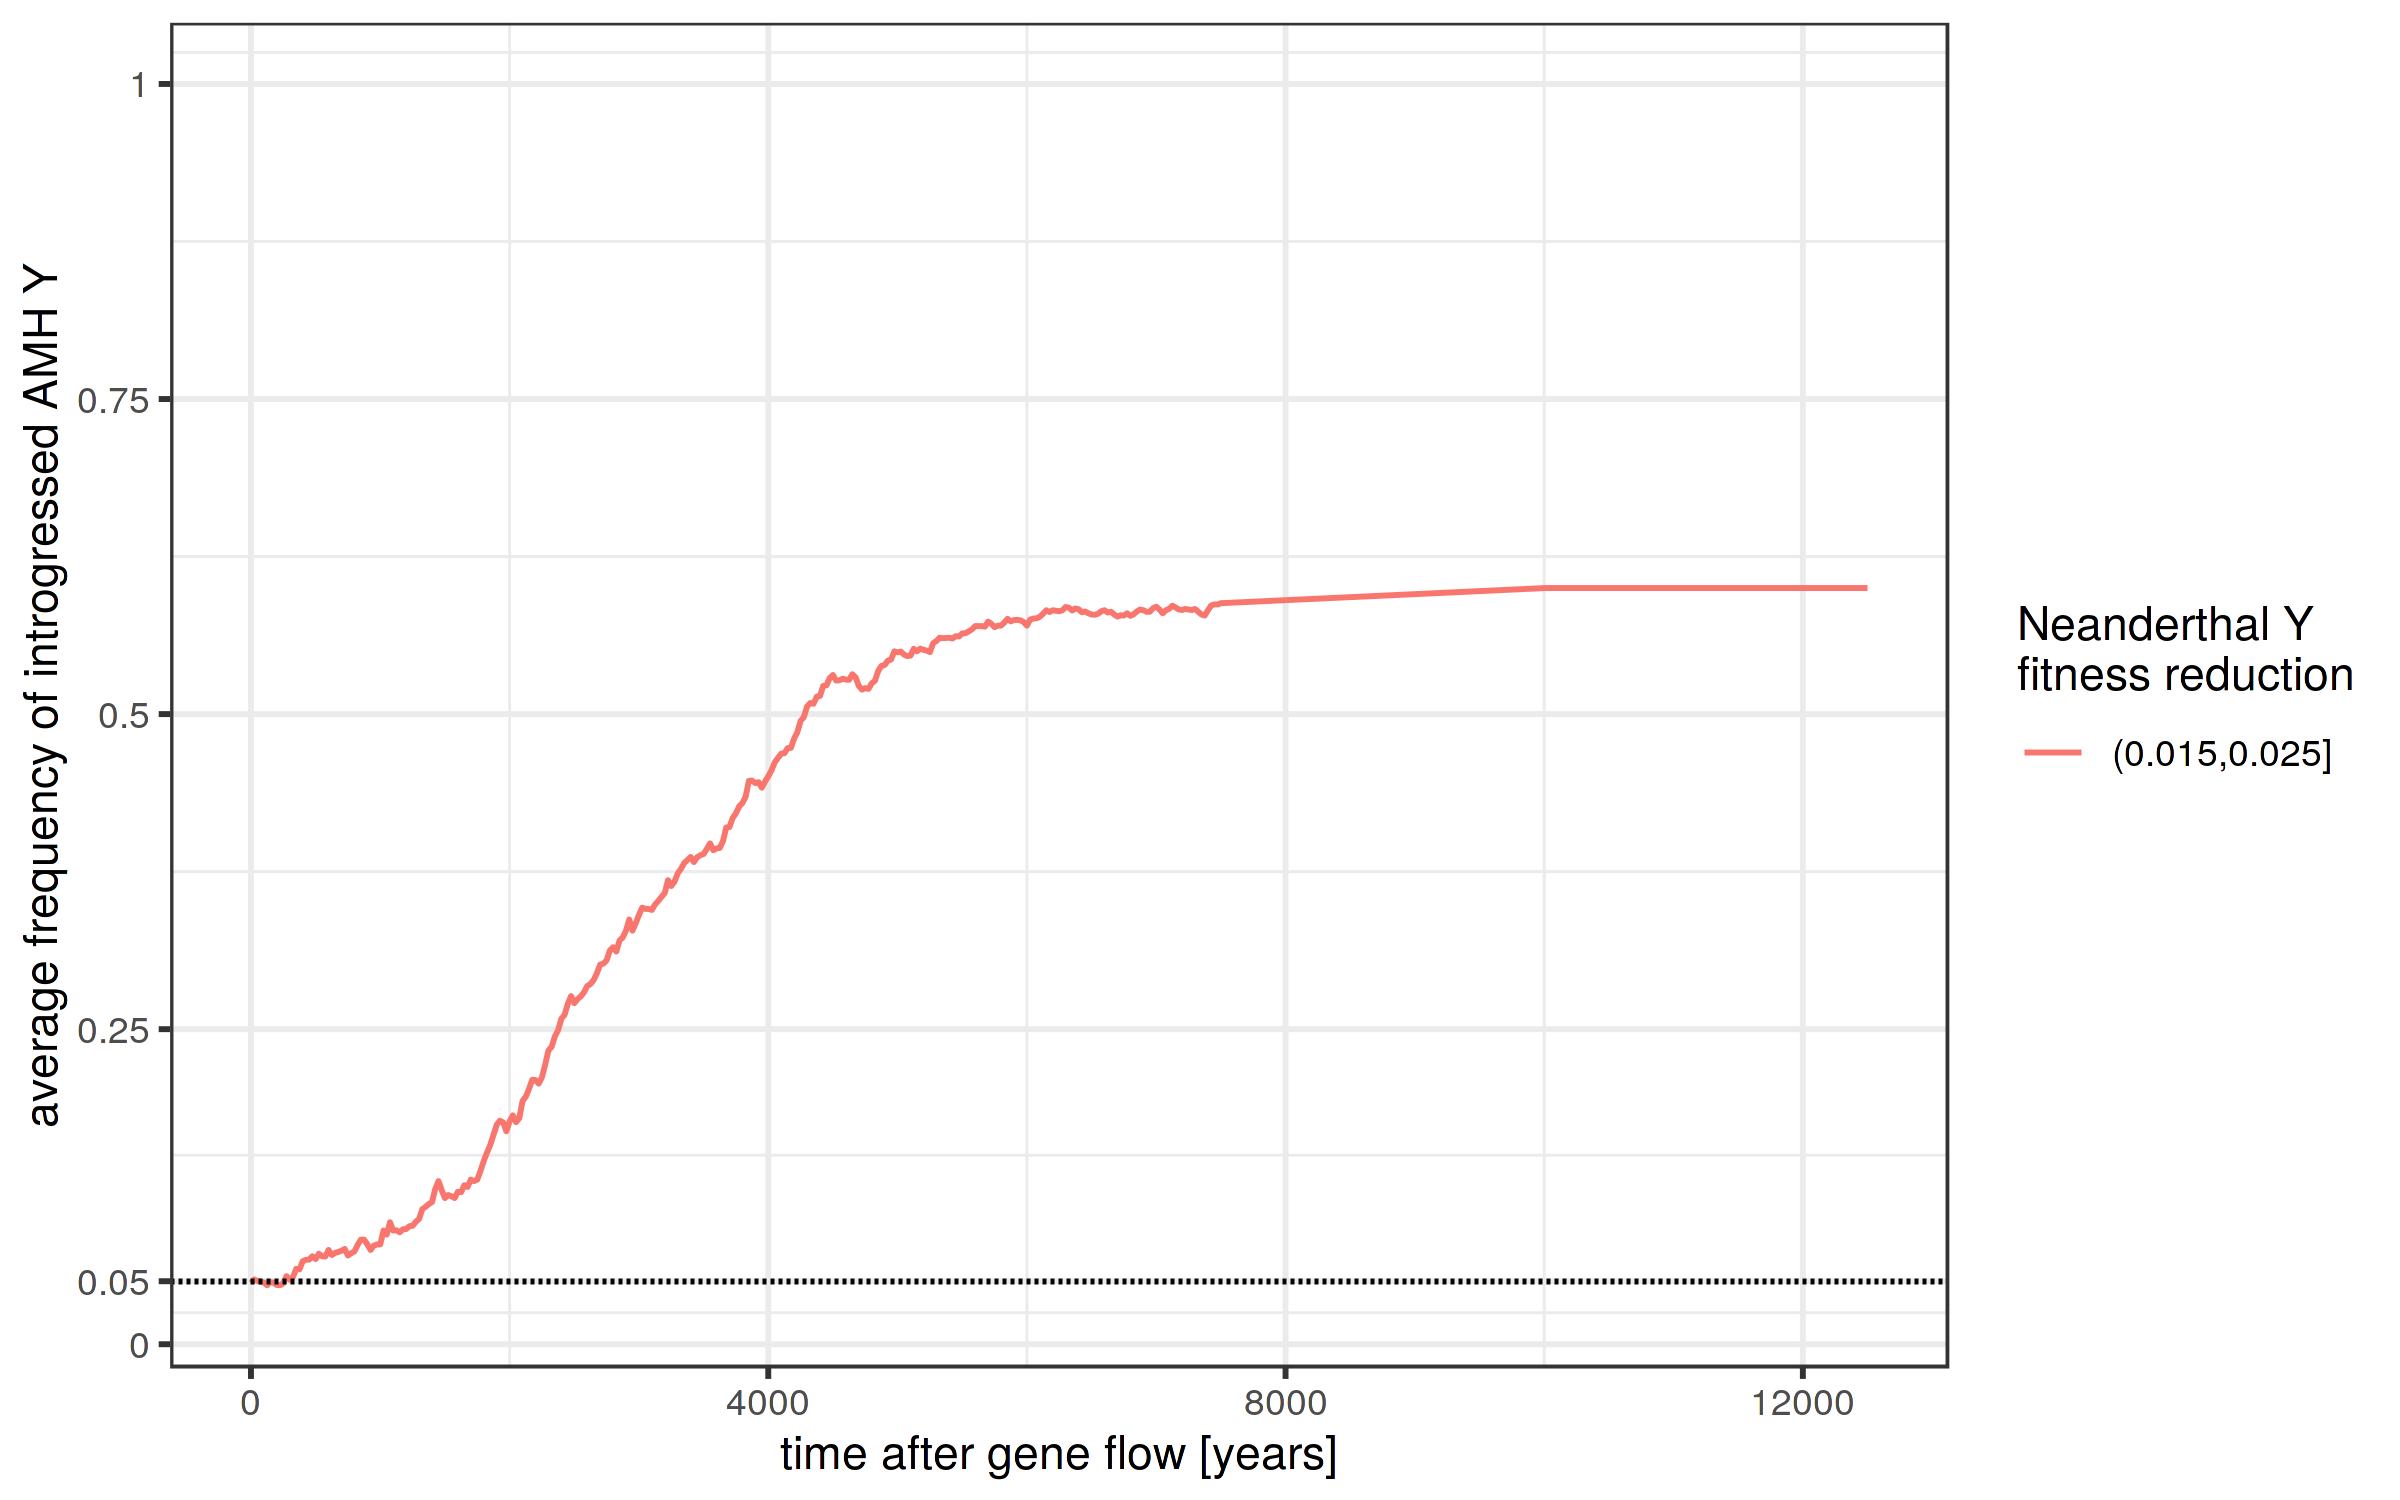

In [43]:
set_dim(8, 5)

mean_traj_fitness %>%
group_by(fitness_bin, gen, time) %>%
summarise_if(is.numeric, mean) %>%
filter(gen < 600) %>%
ggplot(aes(time, ancestry, color = fitness_bin)) +
    geom_line(aes(group = interaction(neand_Ne / human_Ne, admix_rate))) +
    geom_hline(yintercept = 0.05, linetype = 2) +
    theme_bw() +
    labs(color = "Neanderthal Y\nfitness reduction",
         y = "average frequency of introgressed AMH Y",
         x = "time after gene flow [years]") +
    coord_cartesian(y = c(0.03, 1)) +
    scale_y_continuous(breaks = c(0, 0.05, 0.25, 0.5, 0.75, 1), labels = c(0, 0.05, 0.25, 0.5, 0.75, 1))

In [44]:
prob_traj_fitness <- traj_fitness %>%
    group_by(gen, time, human_Ne, neand_Ne, admix_rate) %>%
    summarise(prob_fix = mean(ancestry == 1),
              ratio = mean(ratio))

In [45]:
prob_traj_fitness <- prob_traj_fitness %>% mutate(fitness_bin = cut(ratio, boundaries))

In [46]:
prob_traj_fitness %>% head

gen,time,human_Ne,neand_Ne,admix_rate,prob_fix,ratio,fitness_bin
<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>
0,0,10000,1000,0.05,0,0.01796927,"(0.015,0.025]"
1,25,10000,1000,0.05,0,0.01796927,"(0.015,0.025]"
2,50,10000,1000,0.05,0,0.01796927,"(0.015,0.025]"
3,75,10000,1000,0.05,0,0.01796927,"(0.015,0.025]"
4,100,10000,1000,0.05,0,0.01796927,"(0.015,0.025]"
5,125,10000,1000,0.05,0,0.01796927,"(0.015,0.025]"


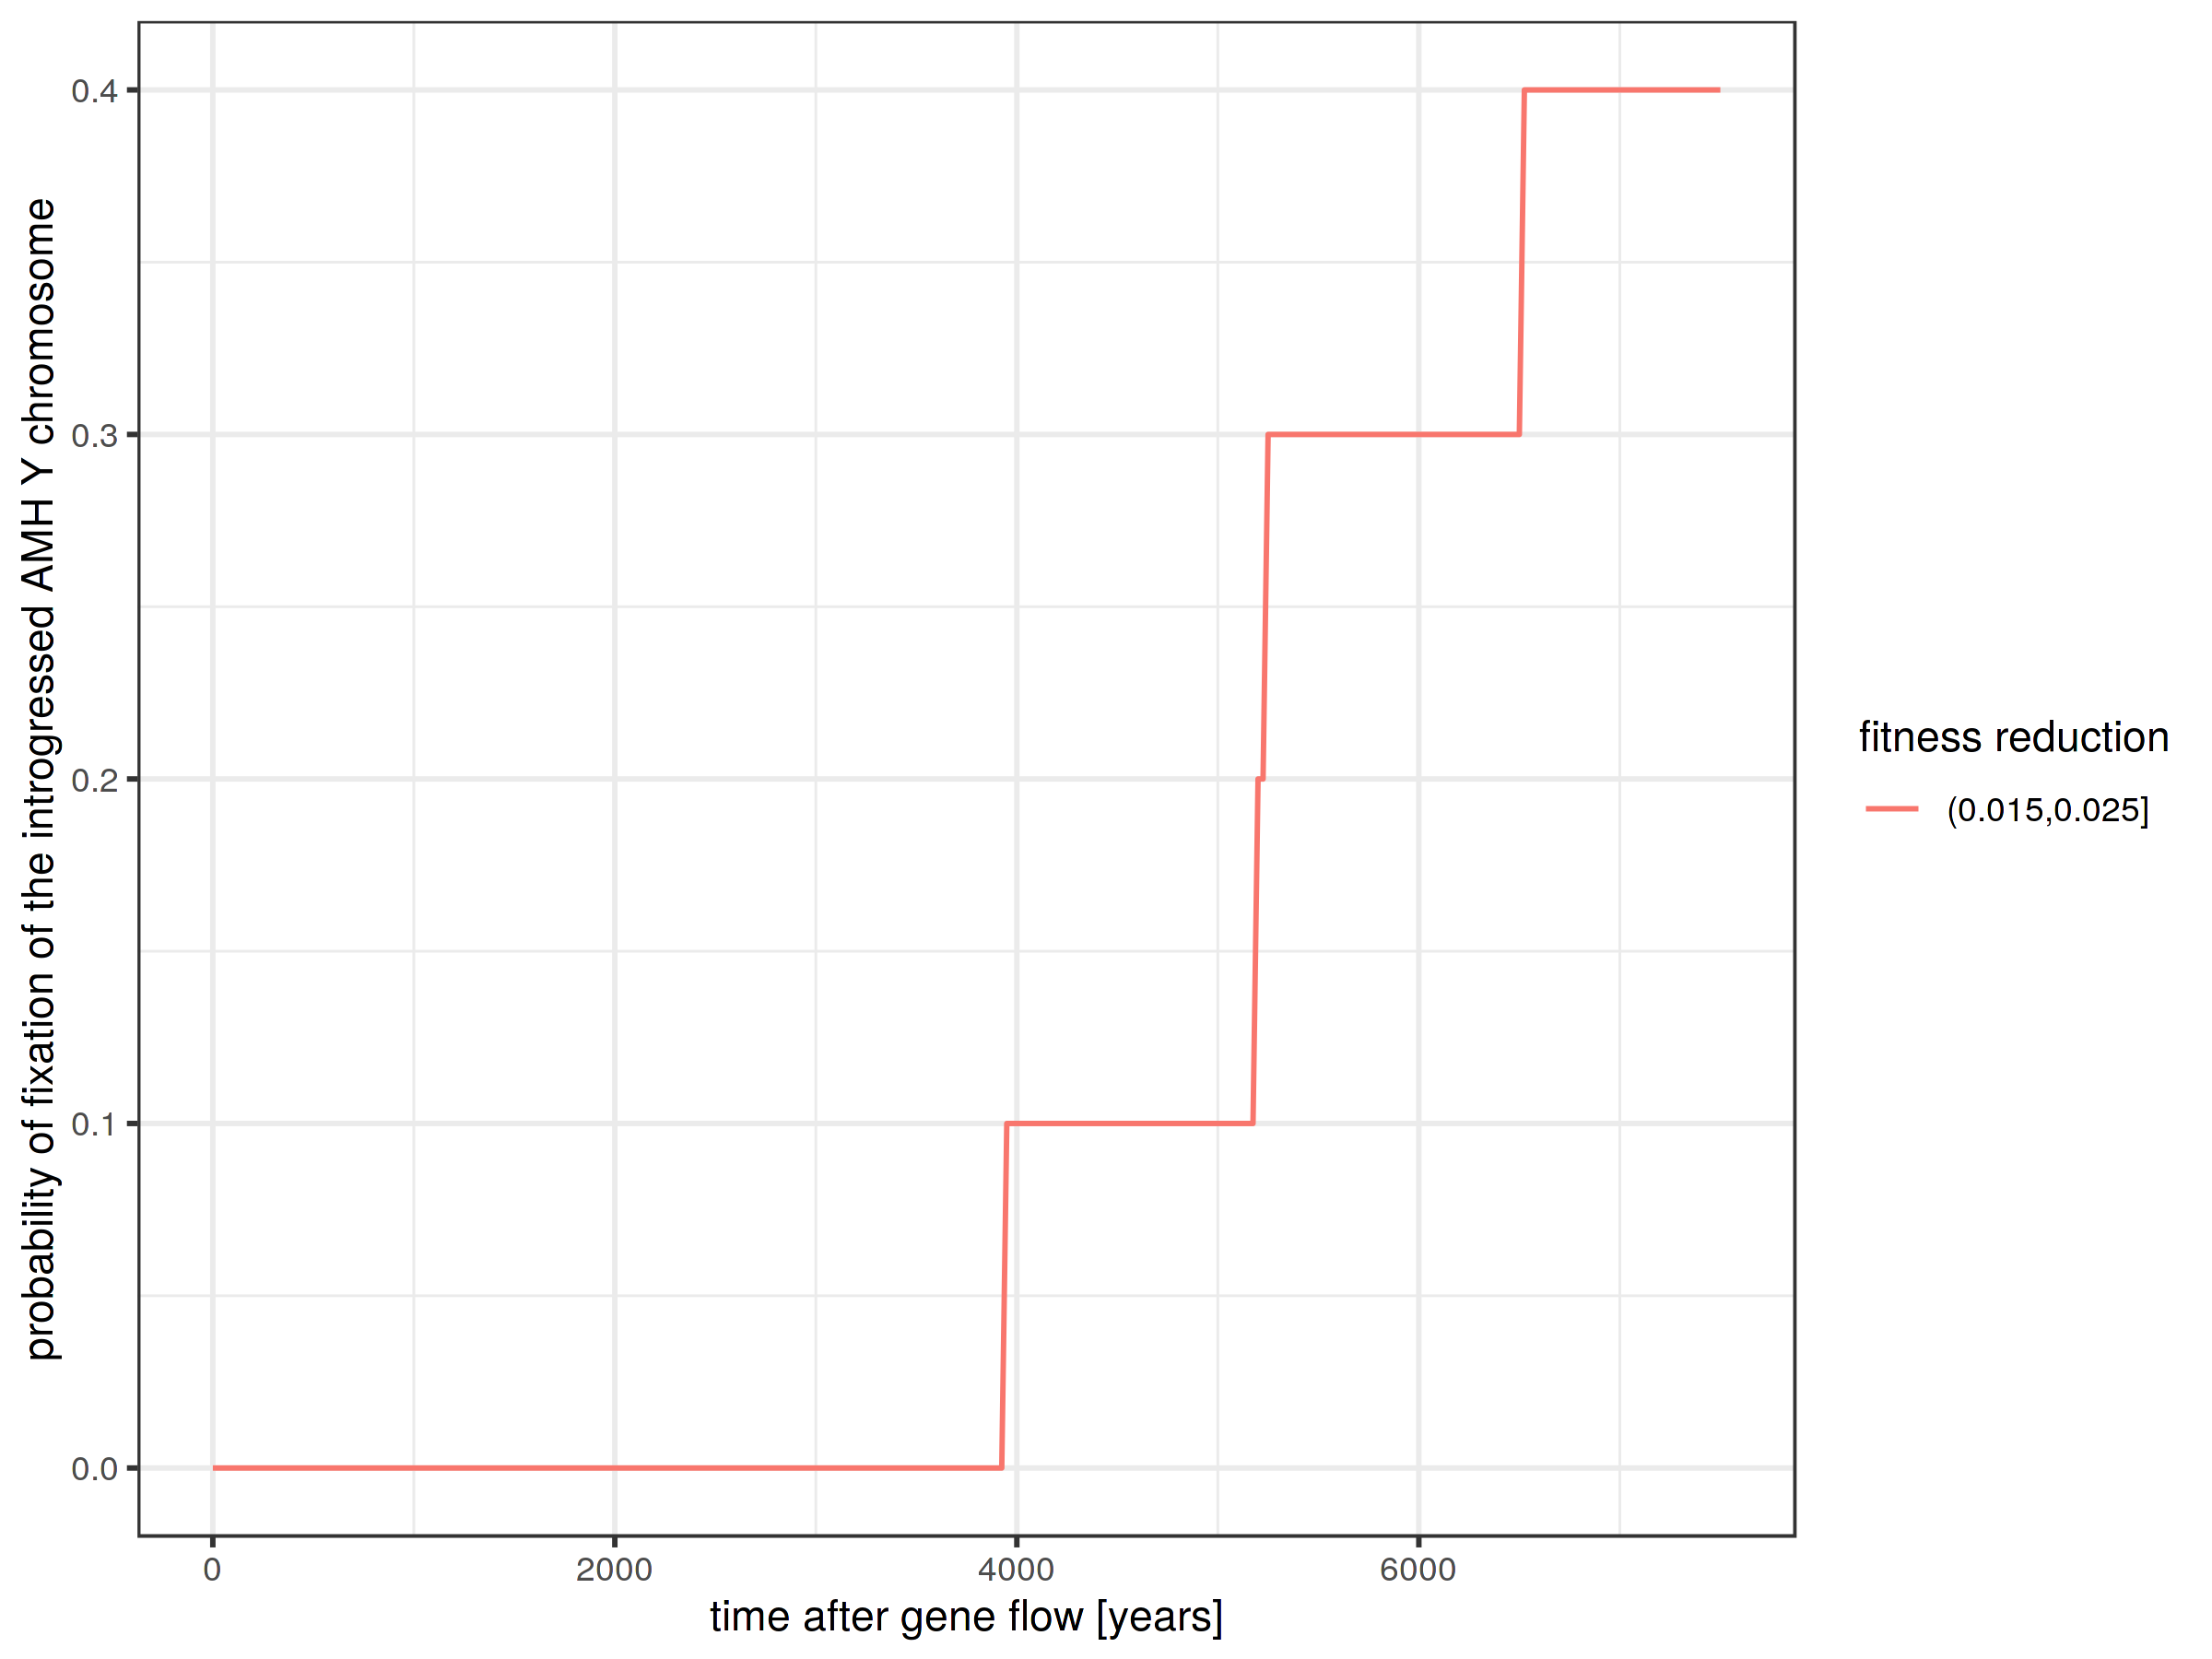

In [47]:
set_dim(8, 6)

prob_traj_fitness %>%
filter(gen < 400) %>%
ggplot(aes(time, prob_fix, color = fitness_bin)) +
    geom_line(aes(group = interaction(neand_Ne / human_Ne, admix_rate))) +
    theme_bw() +
    labs(color = "fitness reduction",
         y = "probability of fixation of the introgressed AMH Y chromosome",
         x = "time after gene flow [years]")

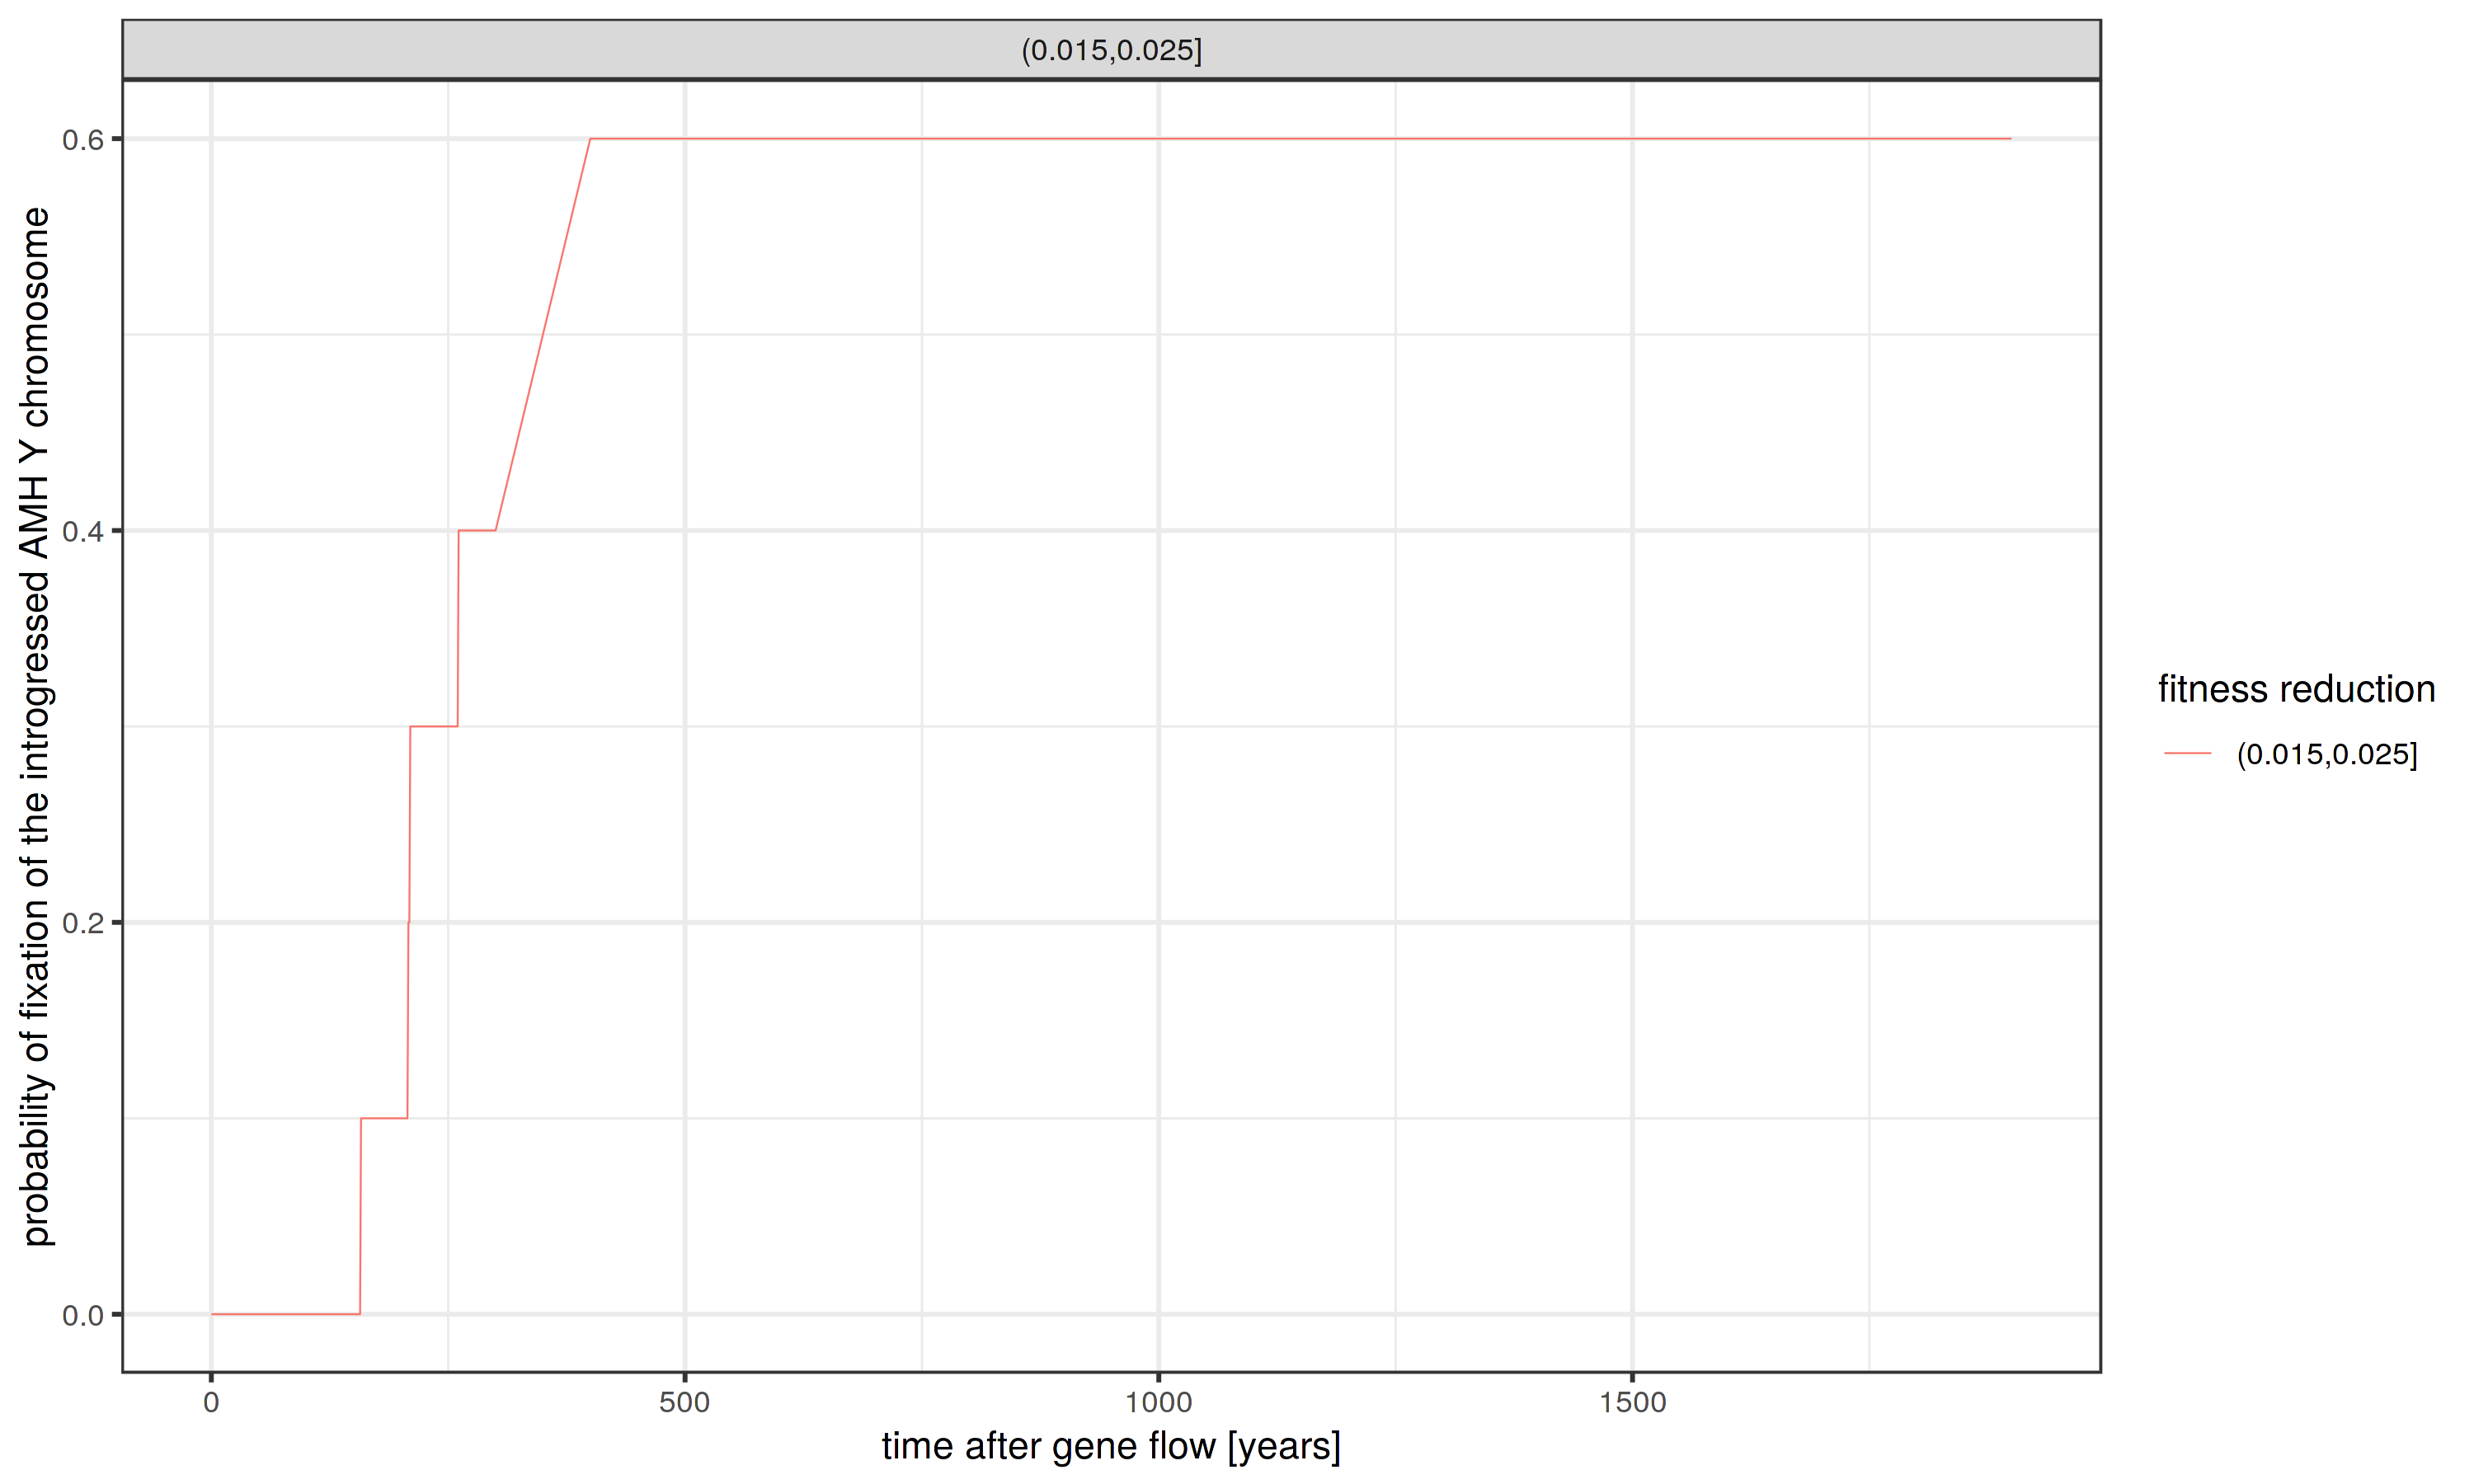

In [48]:
set_dim(10, 6)

prob_traj_fitness %>%
filter(gen < 2000) %>% 
ggplot(aes(gen, prob_fix, color = fitness_bin)) +
    geom_line(aes(group = interaction(neand_Ne / human_Ne, admix_rate)), size = 1/5) +
    facet_wrap(~ fitness_bin) +
    theme_bw() +
    labs(color = "fitness reduction",
         y = "probability of fixation of the introgressed AMH Y chromosome",
         x = "time after gene flow [years]")

Warning message:
“Removed 4620 row(s) containing missing values (geom_path).”


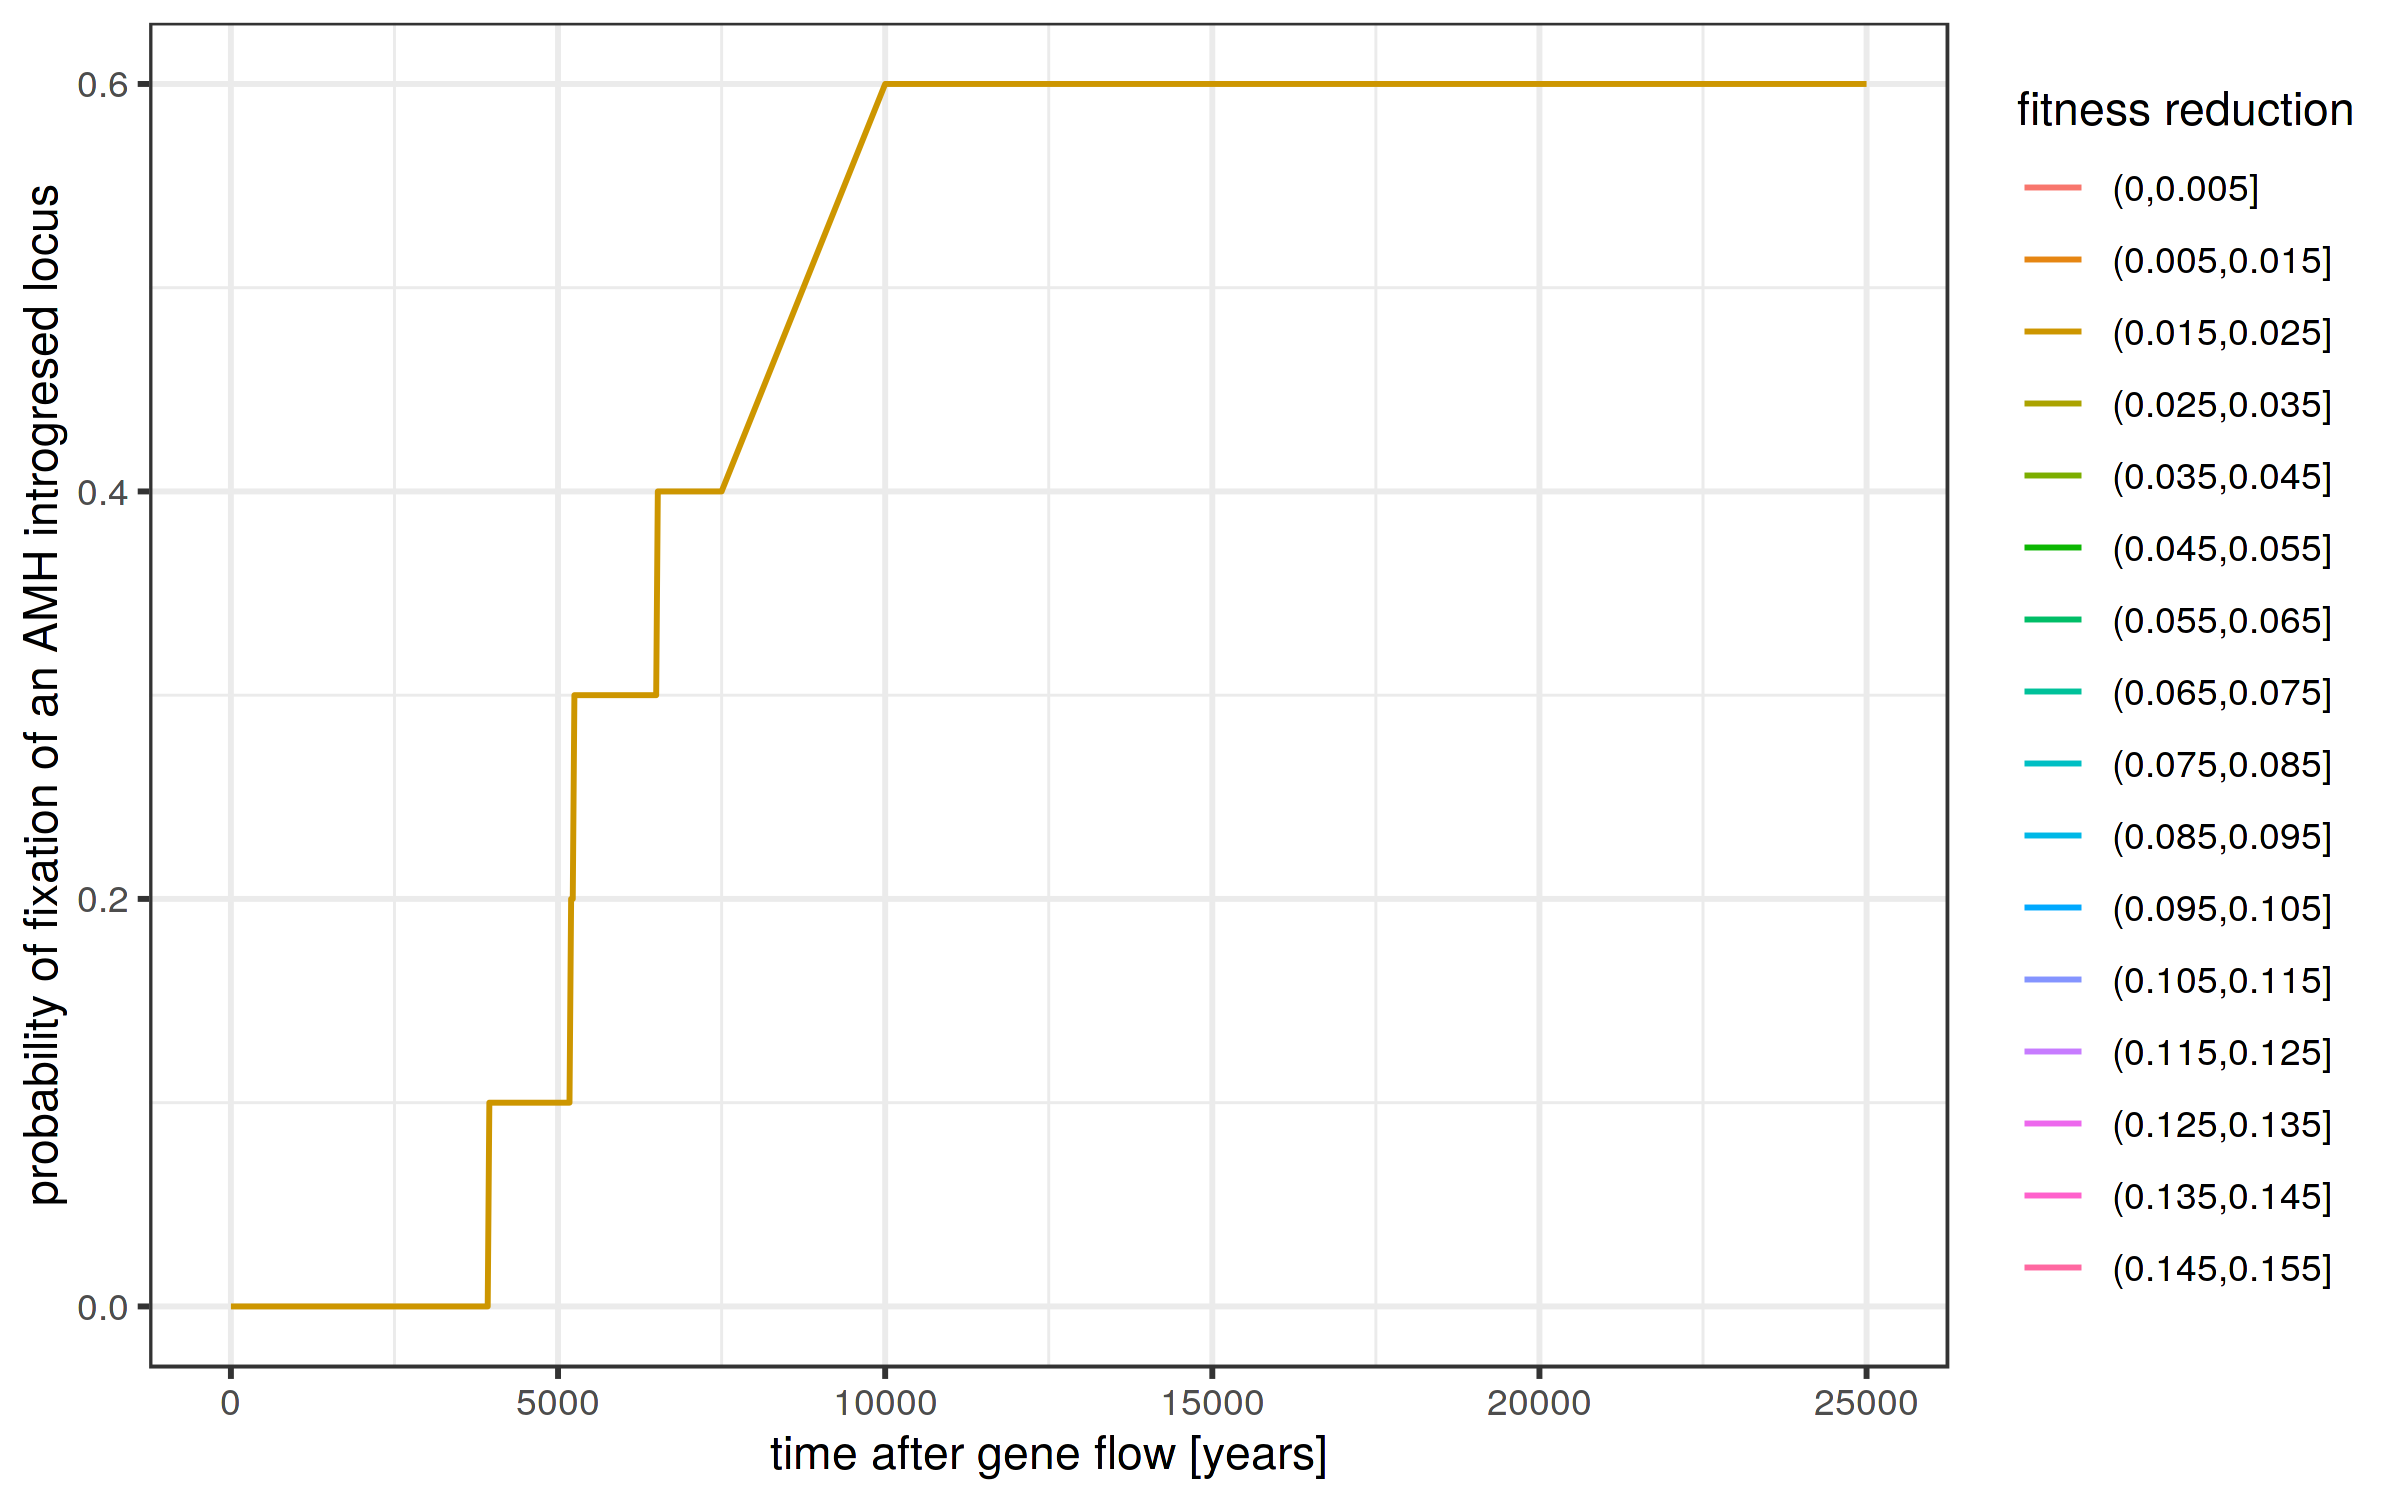

In [49]:
set_dim(8, 5)

prob_traj_fitness %>%
group_by(gen, time, fitness_bin) %>%
summarise_all(mean) %>%
filter(gen <= 1000) %>%
ggplot(aes(time, prob_fix, color = fitness_bin)) +
    geom_line(aes(group = interaction(neand_Ne / human_Ne, admix_rate))) +
    theme_bw() +
    labs(color = "fitness reduction",
         y = "probability of fixation of an AMH introgresed locus",
         x = "time after gene flow [years]")

## Decompose probabilities back on the 2D parameter grid

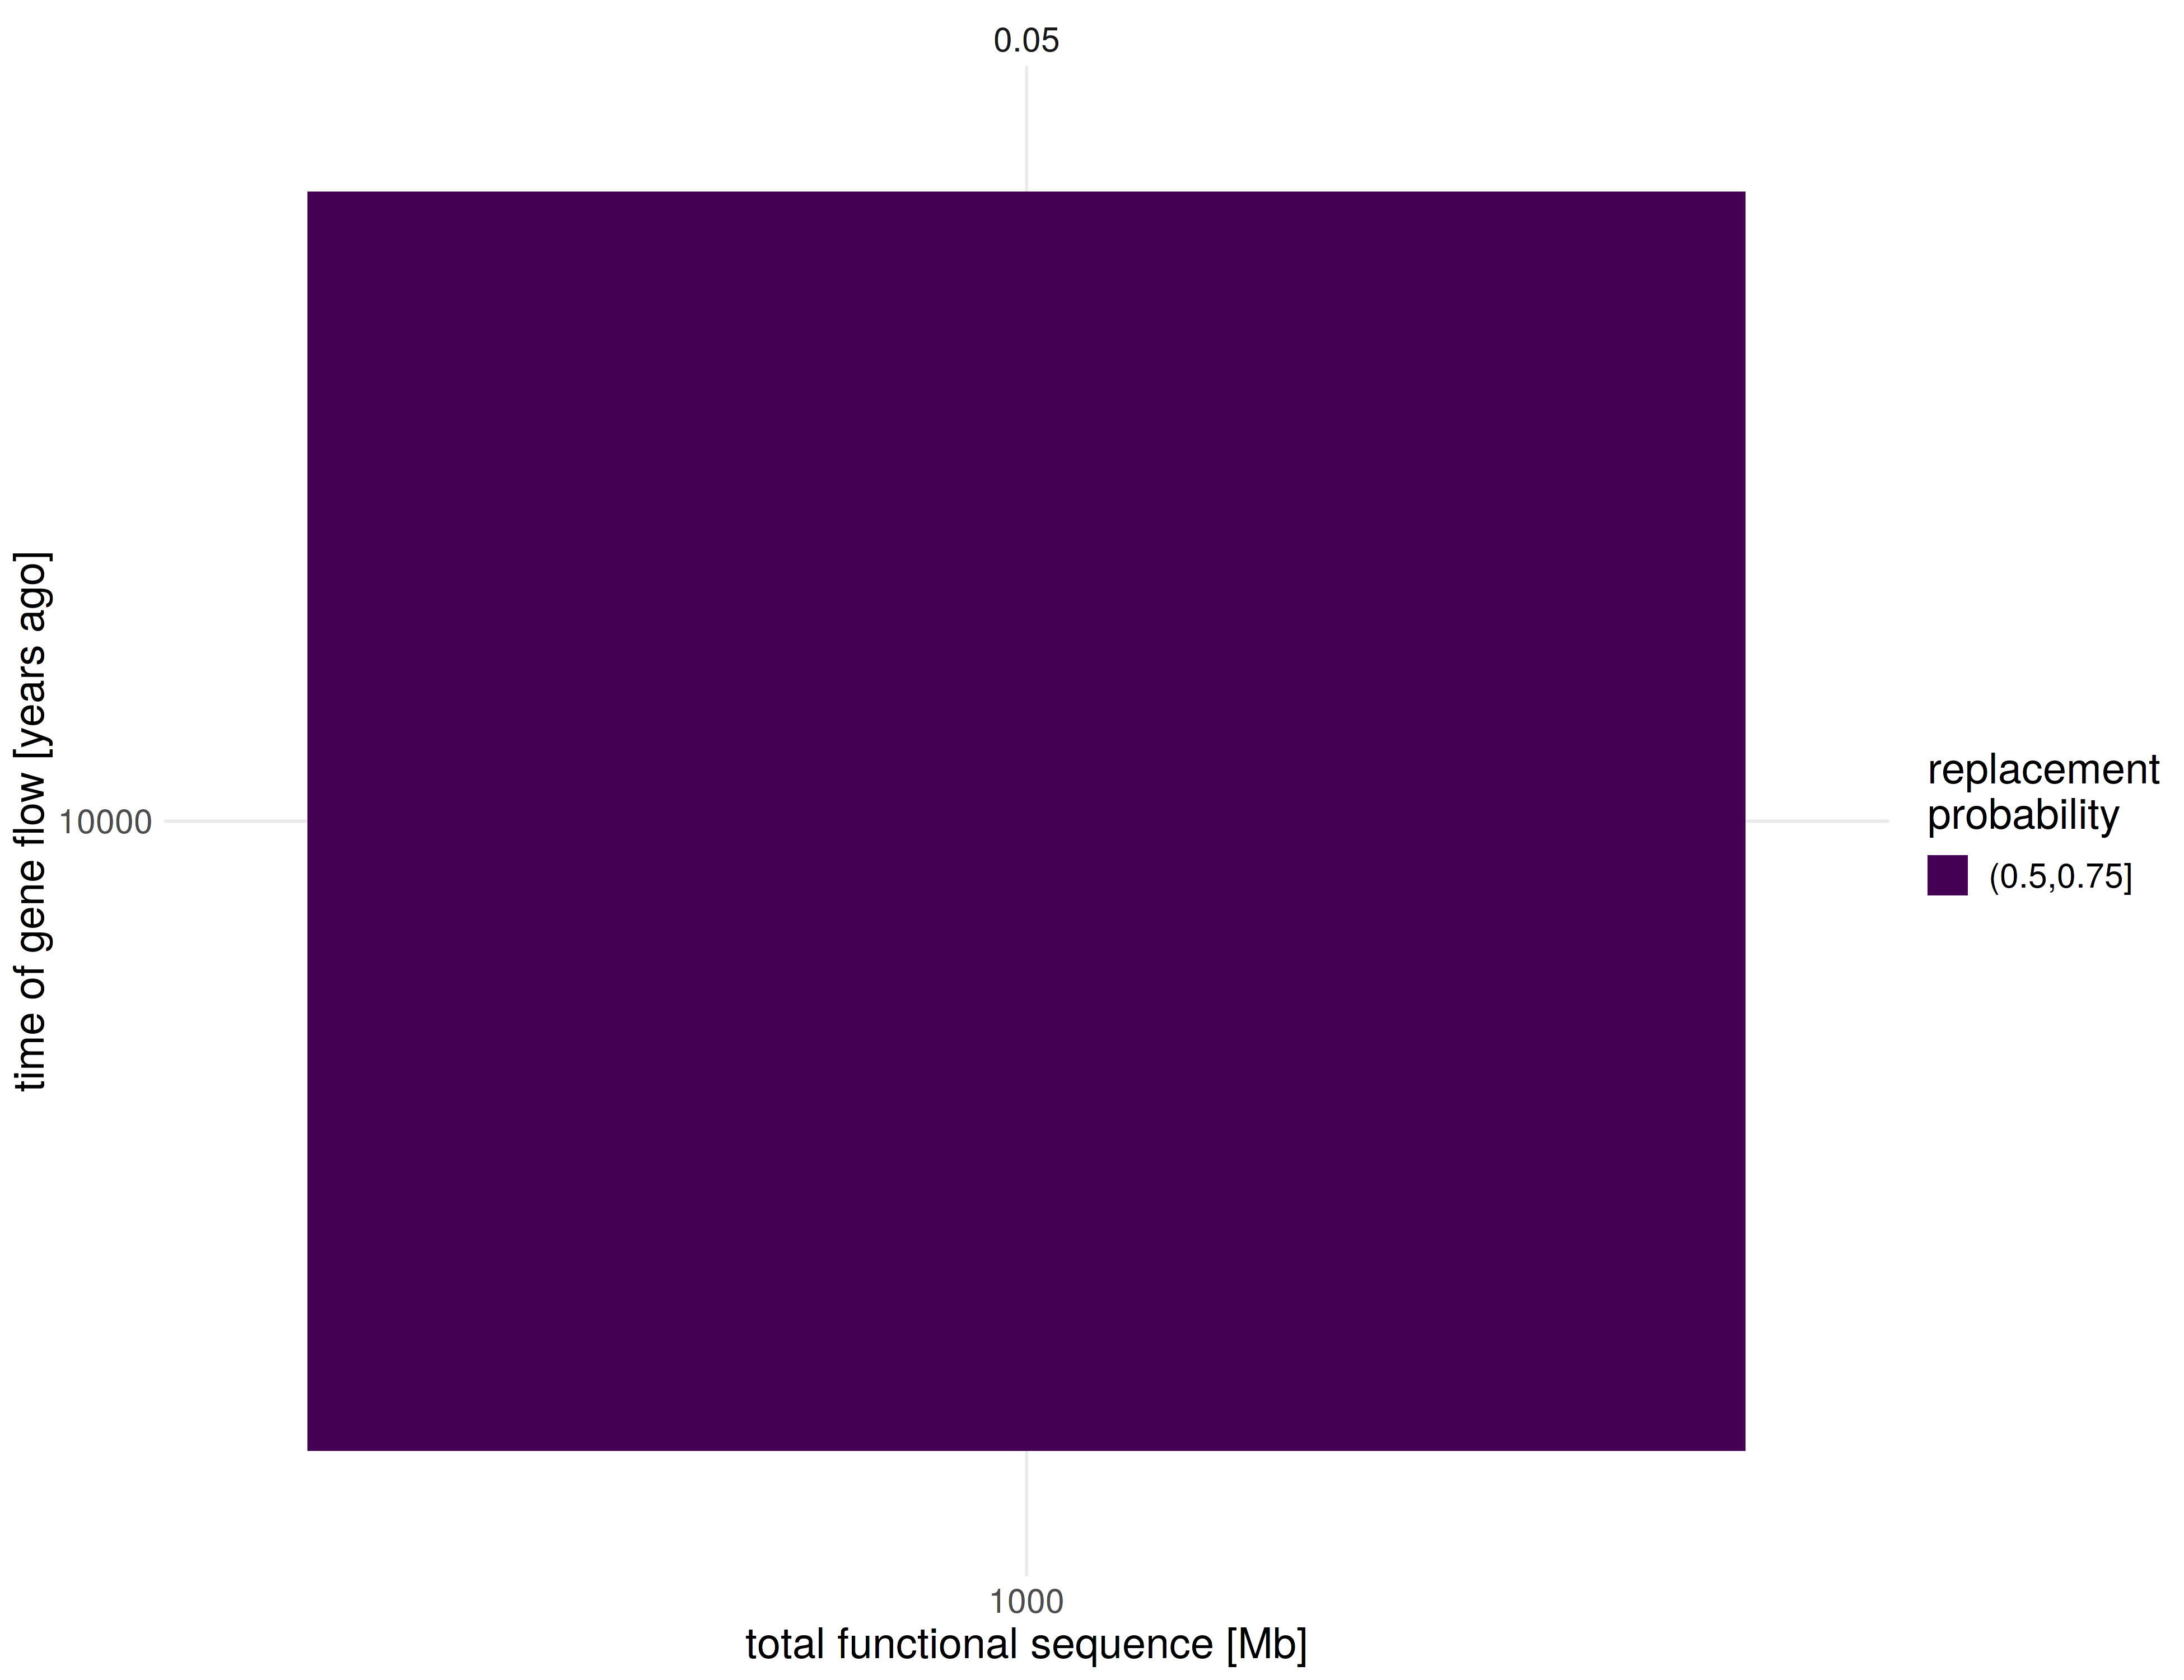

In [50]:
set_dim(13, 10)

prob_traj_fitness %>%
filter(time == 20000) %>%
ungroup %>%
mutate(prob_bin = cut(prob_fix, c(0, 0.1, 0.25, 0.5, 0.75, 0.9, 1))) %>% {
ggplot(data = ., aes(factor(neand_Ne), factor(human_Ne))) +
    geom_tile(aes(fill = prob_bin)) +
    scale_fill_viridis_d() +
    guides(
        fill = guide_legend(title = "replacement\nprobability")
    ) +
    labs(y = "time of gene flow [years ago]", x = "total functional sequence [Mb]") +
    theme_minimal() +
    theme(text = element_text(size = 18)) +
    facet_wrap(~ factor(admix_rate))
}

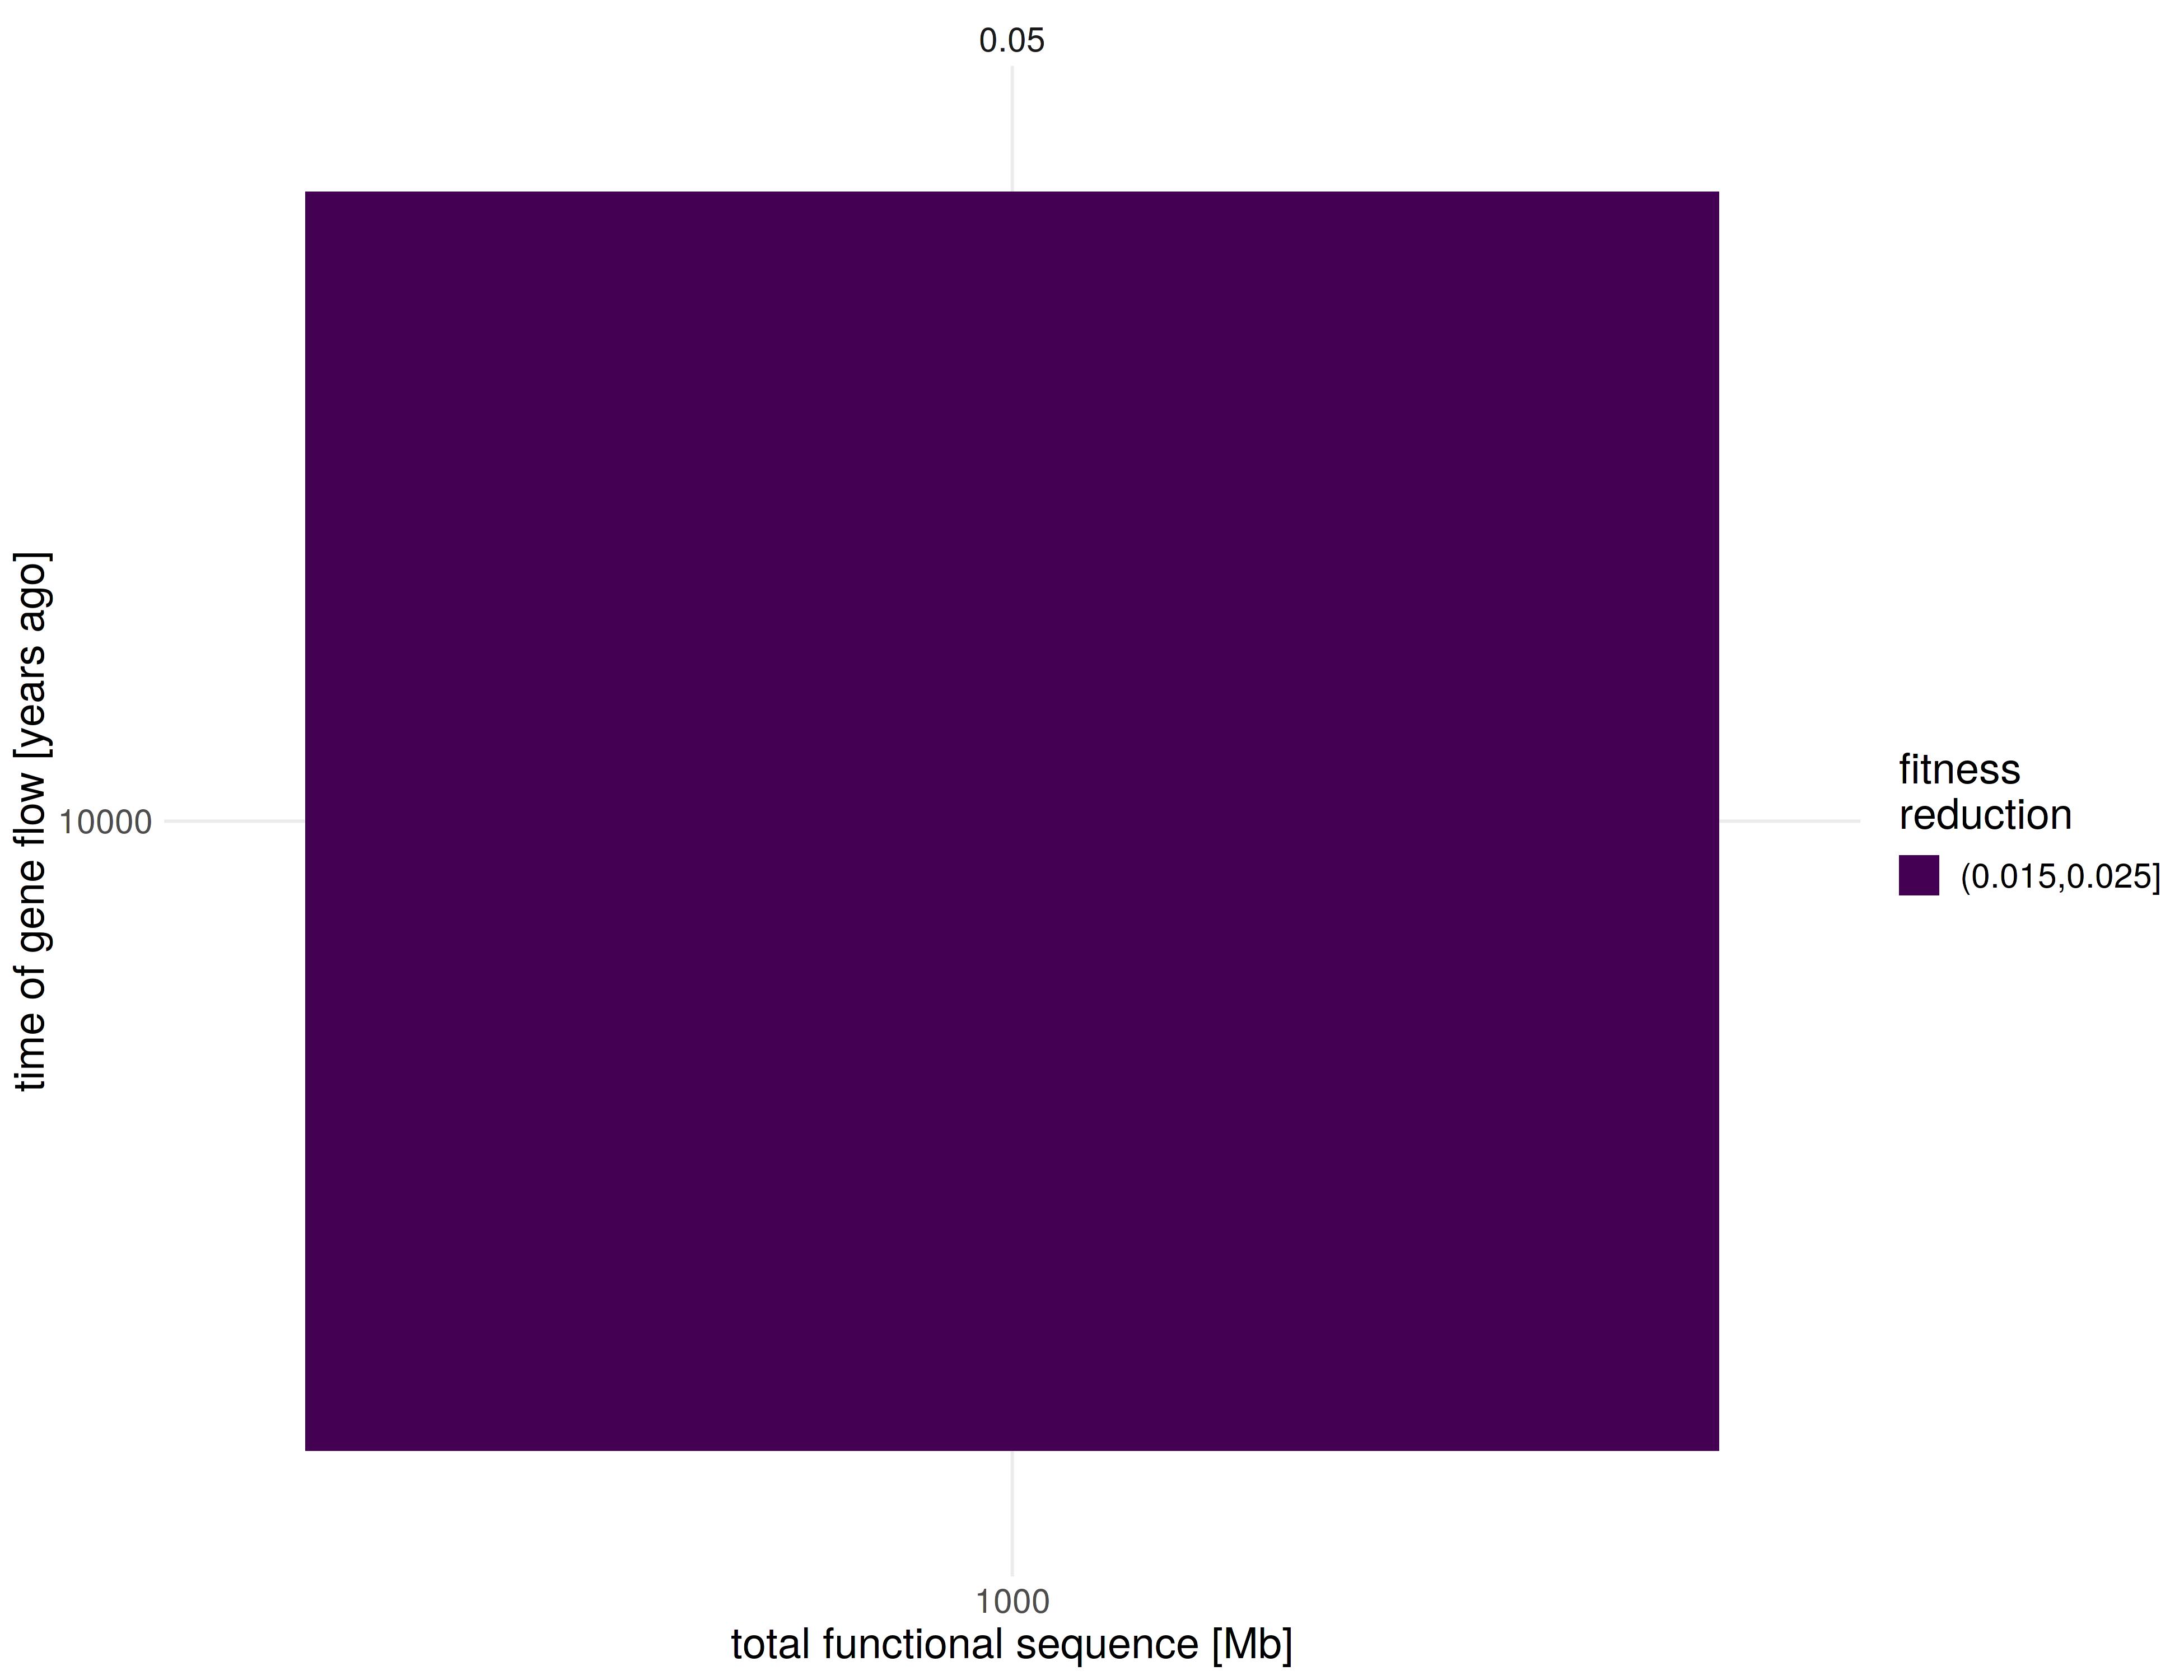

In [51]:
set_dim(13, 10)

prob_traj_fitness %>%
filter(time == 20000) %>%
ungroup %>%
mutate(prob_bin = cut(prob_fix, c(0, 0.1, 0.25, 0.5, 0.75, 0.9, 1))) %>% {
ggplot(data = ., aes(factor(neand_Ne), factor(human_Ne))) +
    geom_tile(aes(fill = fitness_bin)) +
    scale_fill_viridis_d() +
    guides(
        fill = guide_legend(title = "fitness\nreduction")
    ) +
    labs(y = "time of gene flow [years ago]", x = "total functional sequence [Mb]") +
    theme_minimal() +
    theme(text = element_text(size = 18)) +
    facet_wrap(~ factor(admix_rate))
}